In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate
from scipy.stats import chi2
from iminuit import minimize
print('chi2 for 1 sigma = ', chi2.isf(1-0.683, 2, loc=0, scale=1))
print('chi2 for 2 sigma = ', chi2.isf(1-0.954, 2, loc=0, scale=1))

chi2 for 1 sigma =  2.297707010209714
chi2 for 2 sigma =  6.158227764986083


In [2]:
# def printattr(name, object):
#     print(name)
# h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_170_gev_with_spanet_KLFitter.h5', "r")
# h5py_file.visititems(printattr)

## Parameters definition
1. bins_related parameters
* bins_min: The minimum reco top mass (GeV)
* bins_max: The maximum reco top mass (GeV)
* bins_w: The width of each bin
* bins: The boundary of each bin i.g. 120, 121, 122
* The central value of bins will be generated by bins[:-1]+bins_w/2
* bins_dense: Dense version of bins, which is used to draw fitted line

2. Top mass related parameters
* mass: True top mass
* top_mass_dense: True top mass that used to fit and generate pdf
* top_mass_reco_dense: 
* top_mass_chi2: When scanning the top mass pdf, the scan range must be smaller than 170 and larger than 176.
* top_mass_sudo_bins: Used to plot the histogram of the sudo experiment

3. JSF related parameters
* JSF_arr: JSF arr that generates
* JSF_sudo: 
* JSF_reco_dense
* JSF_dense 
* JSF_chi2 
* JSF_sudo_bi

4. Other parameters
* loglikeli_cut: klfitter loglikelihood cut, range between -80 to -50
* marginal_prob_cut: spanet marginal probility cut, range between 0 to 1
* tot_event: for sudo experiment
* N: number of event for each sudo experiment (replaced by applying Poisson to each bin)
* plt_xn, plt_yn: The x and y axis for drawing mutiple JSF value within one plt figure
* plt_fig: The size of plt figure of drawing multiple JSF
* colors: Control the color of drawings
* state_labels: The label of three classes
* langau_fit_labels: The label of parameters for incorrect and unmatched pdf fit
* two_gau_fit_labels: The label of parameters for correct pdf fit

In [25]:
# Fixed the bins, colors, mass arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_dense = np.linspace(bins_min, bins_max, 1000)

mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
top_mass_reco_dense = np.linspace(170, 176, 100)
top_mass_chi2 = np.linspace(166, 180, 1000)
top_mass_sudo_bins = np.arange(166, 180, 0.2)

JSF_arr = [0.97, 0.98, 0.99, 0.995, 1.00, 1.005, 1.01, 1.02, 1.03]
JSF_dense = np.linspace(0.97, 1.03, 1000)
JSF_sudo = [0.98, 0.99, 1.00, 1.01, 1.02]
JSF_reco_dense = np.linspace(0.99, 1.01, 100)
JSF_chi2 = np.linspace(0.97, 1.03, 1000)
JSF_sudo_bins = np.arange(0.97, 1.03, 0.1)

loglikeli_cut = -75
marginal_prob_cut = 0.2

tot_event = 100000
N = 1000

plt_xn, plt_yn = 2, 5
plt_fig = (30, 30*plt_xn/plt_yn)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Mean of Landau', 'Variance of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
two_gau_fit_labels = ['Mean of  first Gaussian', 'Variance of first Gaussian', 'Mean of  second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']

## Function get_reco_top_mass
Input:
1. h5py_file (file containing the data)
2. target (spanet or klfitter)
3. JSF

Output:
1. reconstructed top mass
2. state (class of the top mass, 0 for unmatched, 1 for incorrect, and 2 for correct)
3. cuts: currently reco top mass cut (bins_min < reco top mass < bins_max)
4. loglikelihood value for klfitter; assignment, detection, and marginal probabilities for spanet

In [4]:
def get_reco_top_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)*JSF

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)*JSF

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)*JSF
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    bins_min < reco_m_top < bins_max
    additional cuts (same as CMS)
    """
    """
    # Caululate delR
    lepton_eta = h5py_file['lepton_features/eta'][:]
    lepton_phi = h5py_file['lepton_features/phi'][:]
    jet_eta = h5py_file['jet_features/eta'][:]
    jet_phi = h5py_file['jet_features/phi'][:]
    del_eta = np.array([jet_eta[i, :4] - lepton_eta[i] for i in range(len(jet_eta))])
    del_phi = np.abs([jet_phi[i, :4] - lepton_phi[i] for i in range(len(jet_eta))])
    del_phi = np.where(del_phi < np.pi, del_phi, 2*np.pi-del_phi)
    delR = np.sqrt(del_eta**2 + del_phi**2)

    # cuts
    # pid 11 is electron, 13 is muon.
    cut_reco_top = np.logical_and(dic['reconstructed_top_mass'] > bins_min, dic['reconstructed_top_mass'] < bins_max)
    cut_lepton_pt = np.logical_or(
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
    cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
    cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
            np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
    cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
    cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                        abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
    cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
    cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))
    """
    cuts = np.logical_and(dic['reconstructed_top_mass'] > bins_min, dic['reconstructed_top_mass'] < bins_max)

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, cuts, h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, cuts, h5py_file['spanet/right_target/assignment_probability'][:], h5py_file['spanet/right_target/detection_probability'][:], h5py_file['spanet/right_target/marginal_probability'][:]

## Data input
Using the function get_reco_top_mass to retrieve the data from the h5py files

In [7]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_spanet_dic, state_spanet_dic, cut_spanet_dic = {}, {}, {}
reco_klf_dic, state_klf_dic, cut_klf_dic = {}, {}, {}
loglikeli_klf_dic, assignment_spanet_dic, detection_spanet_dic, marginal_spanet_dic = {}, {}, {}, {}

for m in mass:
    for JSF in JSF_arr:
        h5py_file = h5py.File('ttbar_testing/ttbar_testing_{}_gev.h5'.format(m), "r")
        reco_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], assignment_spanet_dic[(m, JSF)], detection_spanet_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)] = get_reco_top_mass(h5py_file, 'spanet', JSF)
        h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
        reco_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]  = get_reco_top_mass(h5py_file, 'klfitter', JSF)

/tmp/ipykernel_8867/1609632559.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


In [32]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between bins_min and bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, bins_min, bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
# Nomalized
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Normalized between bins_min and bins_max
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, bins_min, bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Function to construct PDF parameters
def linear_parabola(x, a, b, c, d, e):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1) + e*(x[1]-1)**2)

# Function to construct PDF parameters
def linear_fourth(x, a, b, c, d, e, f, g):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1) + e*(x[1]-1)**2 + f*(x[1]-1)**3 + g*(x[1]-1)**4)

# mt1 is the observation, n2 is the height of the bins from pdf. (Just a test to check whether th fit is good.
# If so, the chi2 value should be close the the number of bins, which is 120.)
def chi2_pdf(observed, pdf):
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

# Gaussian distributions.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

## Fraction of each class

In [30]:
ratio_klf_dic = {i:{} for i in [0, 1, 2]}
for m in mass:
    for JSF in JSF_arr:
        for state_i in [0, 1, 2]:
            ratio = np.count_nonzero(state_klf_dic[(m, JSF)][np.logical_and(cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>loglikeli_cut)]==state_i)/len(state_klf_dic[(m, JSF)][np.logical_and(cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>loglikeli_cut)])
            ratio_klf_dic[state_i][(m, JSF)] = ratio

fpdf_klf_popt = {}
fpdf_klf_perr = {}
for state_i in [0, 1, 2]:
    popt, pcov = optimize.curve_fit(linear_parabola, np.transpose(list(ratio_klf_dic[state_i].keys())), [ratio_klf_dic[state_i][key] for key in ratio_klf_dic[state_i]], p0 = (0.33, 0, 1, 0, 0), bounds=((0, -0.1, 0, -1, -10), (2, 0.1, 2, 1, 10)))
    perr = np.sqrt(np.diag(pcov))
    fpdf_klf_popt[state_i] = popt
    fpdf_klf_perr[state_i] = perr

In [15]:
# plt.figure(figsize=(30,20))
# for state_i in [0, 1, 2]:
    
#     plt.subplot(2, 3, state_i+1)
#     for JSF in JSF_arr:
#         plt.scatter(mass, [ratio_klf_dic[state_i][(m, JSF)] for m in mass], label='JSF = {}'.format(JSF))
#         plt.plot(top_mass_dense, linear_parabola([top_mass_dense, np.array([JSF]*1000)], *fpdf_klf_popt[state_i]), '--')
#     plt.title('KLF ' + state_labels[state_i])
#     plt.xlabel('top mass (GeV)')
#     plt.ylabel(state_labels[state_i] + ' ratio')
#     plt.legend(loc='upper right')

#     plt.subplot(2, 3, state_i+4)
#     for m in mass:
#         plt.scatter(JSF_arr, [ratio_klf_dic[state_i][(m, JSF)] for JSF in JSF_arr], label='top mass = {}'.format(m))
#         plt.plot(JSF_dense, linear_parabola([np.array([m]*1000), JSF_dense], *fpdf_klf_popt[state_i]), '--')
#     plt.title('KLF ' + state_labels[state_i])
#     plt.xlabel('JSF')
#     plt.ylabel(state_labels[state_i] + ' ratio')
#     plt.legend(loc='upper right')
# plt.show()

In [16]:
ratio_spanet_dic = {i:{} for i in [0, 1, 2]}
for m in mass:
    for JSF in JSF_arr:
        for state_i in [0, 1, 2]:
            ratio = np.count_nonzero(state_spanet_dic[(m, JSF)][np.logical_and(cut_spanet_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)]>marginal_prob_cut)]==state_i)/len(state_spanet_dic[(m, JSF)][np.logical_and(cut_spanet_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)]>marginal_prob_cut)])
            ratio_spanet_dic[state_i][(m, JSF)] = ratio

fpdf_spanet_popt = {}
fpdf_spanet_perr = {}
for state_i in [0, 1, 2]:
    popt, pcov = optimize.curve_fit(linear_parabola, np.transpose(list(ratio_spanet_dic[state_i].keys())), [ratio_spanet_dic[state_i][key] for key in ratio_spanet_dic[state_i]], p0 = (0.33, 0, 1, 0, 0), bounds=((0, -0.1, 0, -1, -10), (2, 0.1, 2, 1, 10)))
    perr = np.sqrt(np.diag(pcov))
    fpdf_spanet_popt[state_i] = popt
    fpdf_spanet_perr[state_i] = perr

In [17]:
# plt.figure(figsize=(30,20))
# for state_i in [0, 1, 2]:

#     plt.subplot(2, 3, state_i+1)
#     for JSF in JSF_arr:
#         plt.scatter(mass, [ratio_spanet_dic[state_i][(m, JSF)] for m in mass], label='JSF = {}'.format(JSF))
#         plt.plot(top_mass_dense, linear_parabola([top_mass_dense, np.array([JSF]*1000)], *fpdf_spanet_popt[state_i]), '--')
#     plt.title('spanet ' + state_labels[state_i])
#     plt.xlabel('top mass (GeV)')
#     plt.ylabel(state_labels[state_i] + ' ratio')
#     plt.legend(loc='upper right')

#     plt.subplot(2, 3, state_i+4)
#     for m in mass:
#         plt.scatter(JSF_arr, [ratio_spanet_dic[state_i][(m, JSF)] for JSF in JSF_arr], label='top mass = {}'.format(m))
#         plt.plot(JSF_dense, linear_parabola([np.array([m]*1000), JSF_dense], *fpdf_spanet_popt[state_i]), '--')
#     plt.title('spanet ' + state_labels[state_i])
#     plt.xlabel('JSF')
#     plt.ylabel(state_labels[state_i] + ' ratio')
#     plt.legend(loc='upper right')
# plt.show()

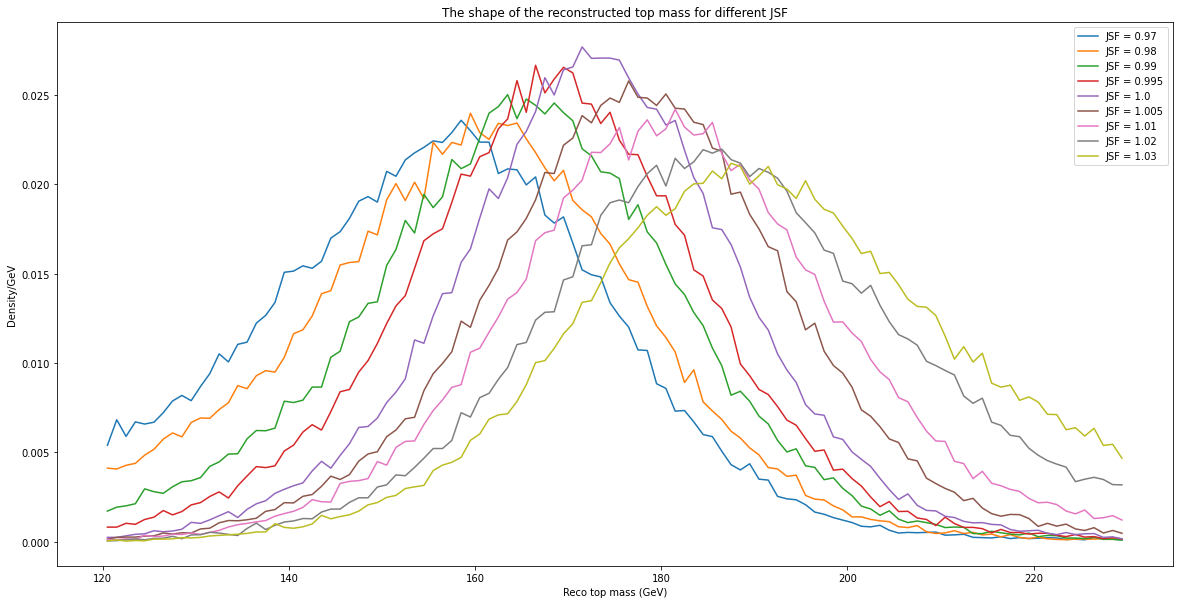

In [31]:
plt.figure(figsize=(20, 10))
for state_i in [2]:
    for m in [173]:
        for JSF in JSF_arr:
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))]
            hist, _ = np.histogram(fit_target, bins=bins, density=True)
            plt.plot(bins[:-1]+0.5, hist, label='JSF = {}'.format(JSF))
plt.legend()
plt.title('The shape of the reconstructed top mass for different JSF')
plt.xlabel('Reco top mass (GeV)')
plt.ylabel('Density/GeV')
plt.show()

## PDF fit and PDF parameters fit

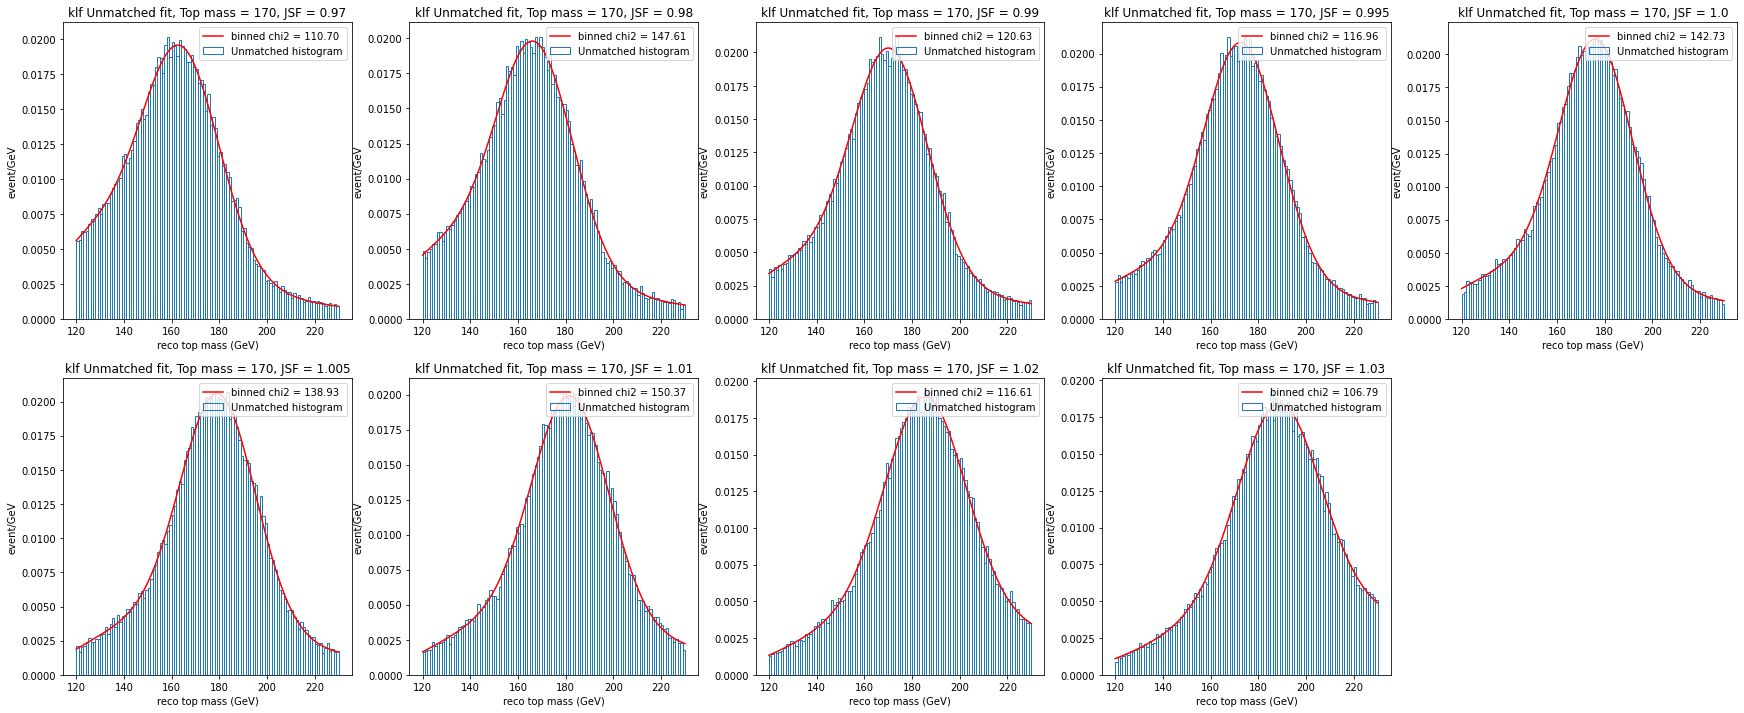

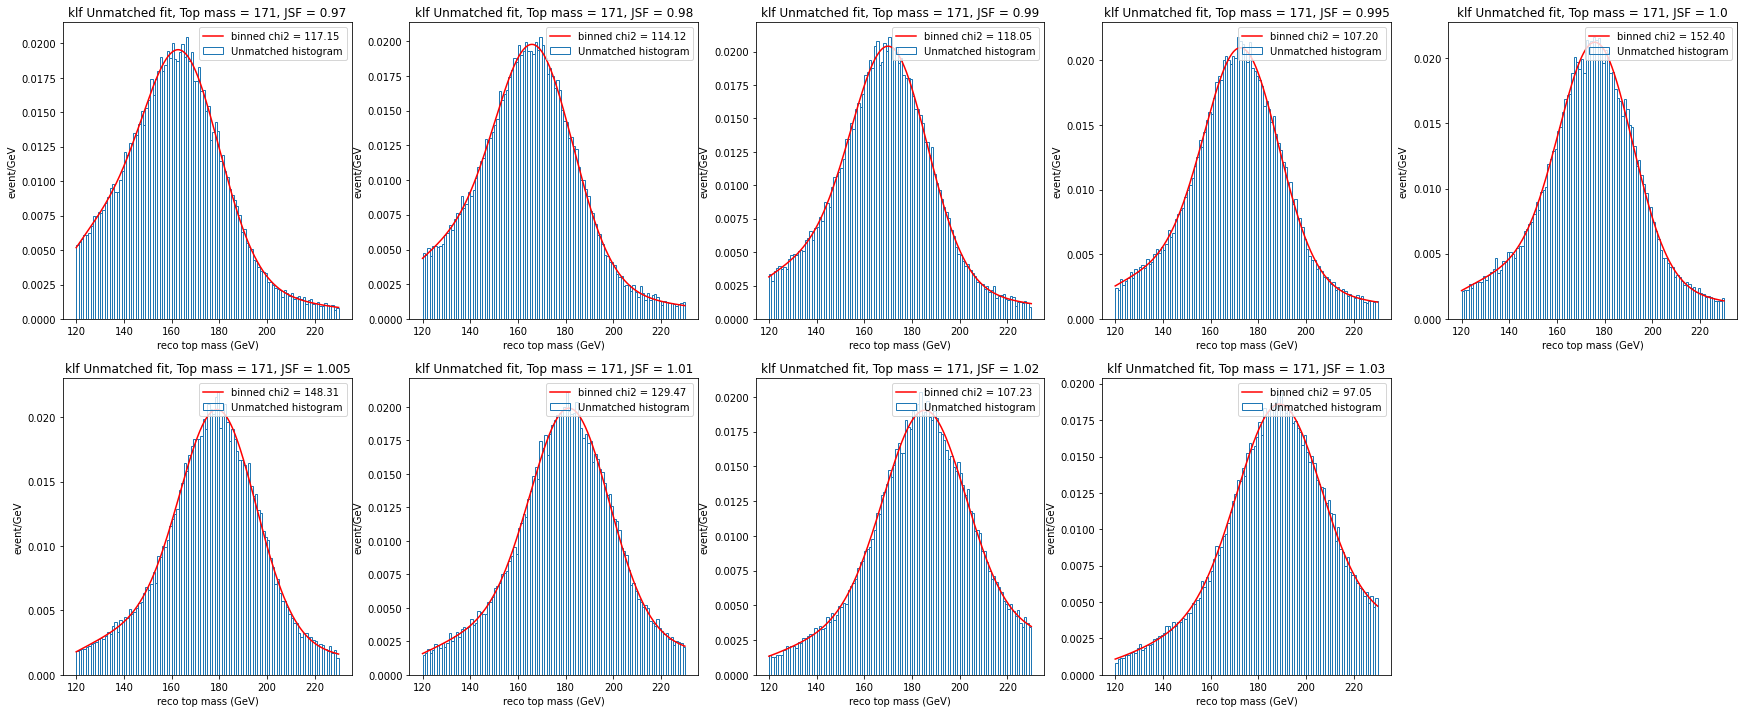

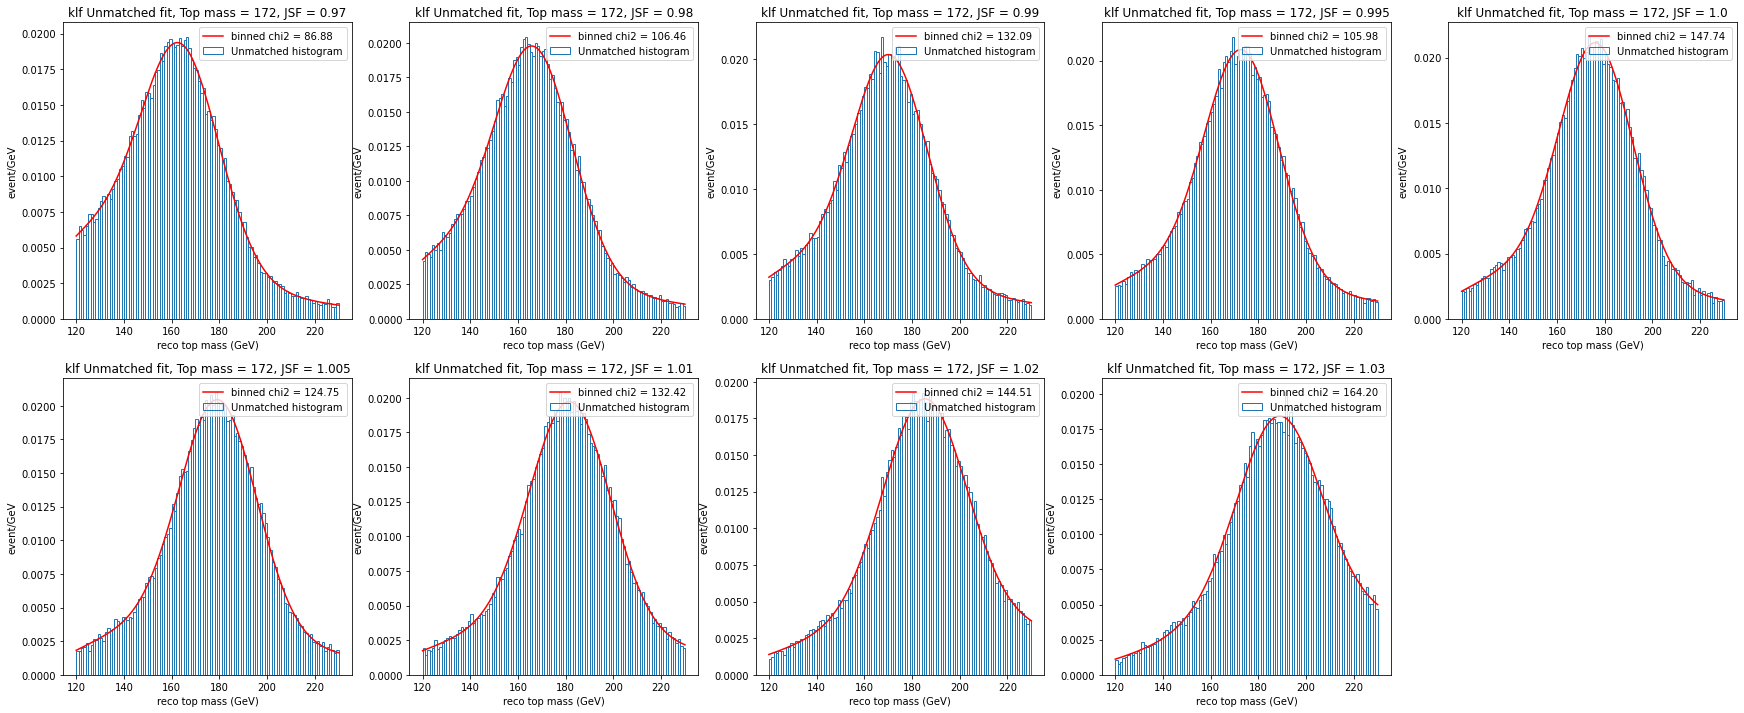

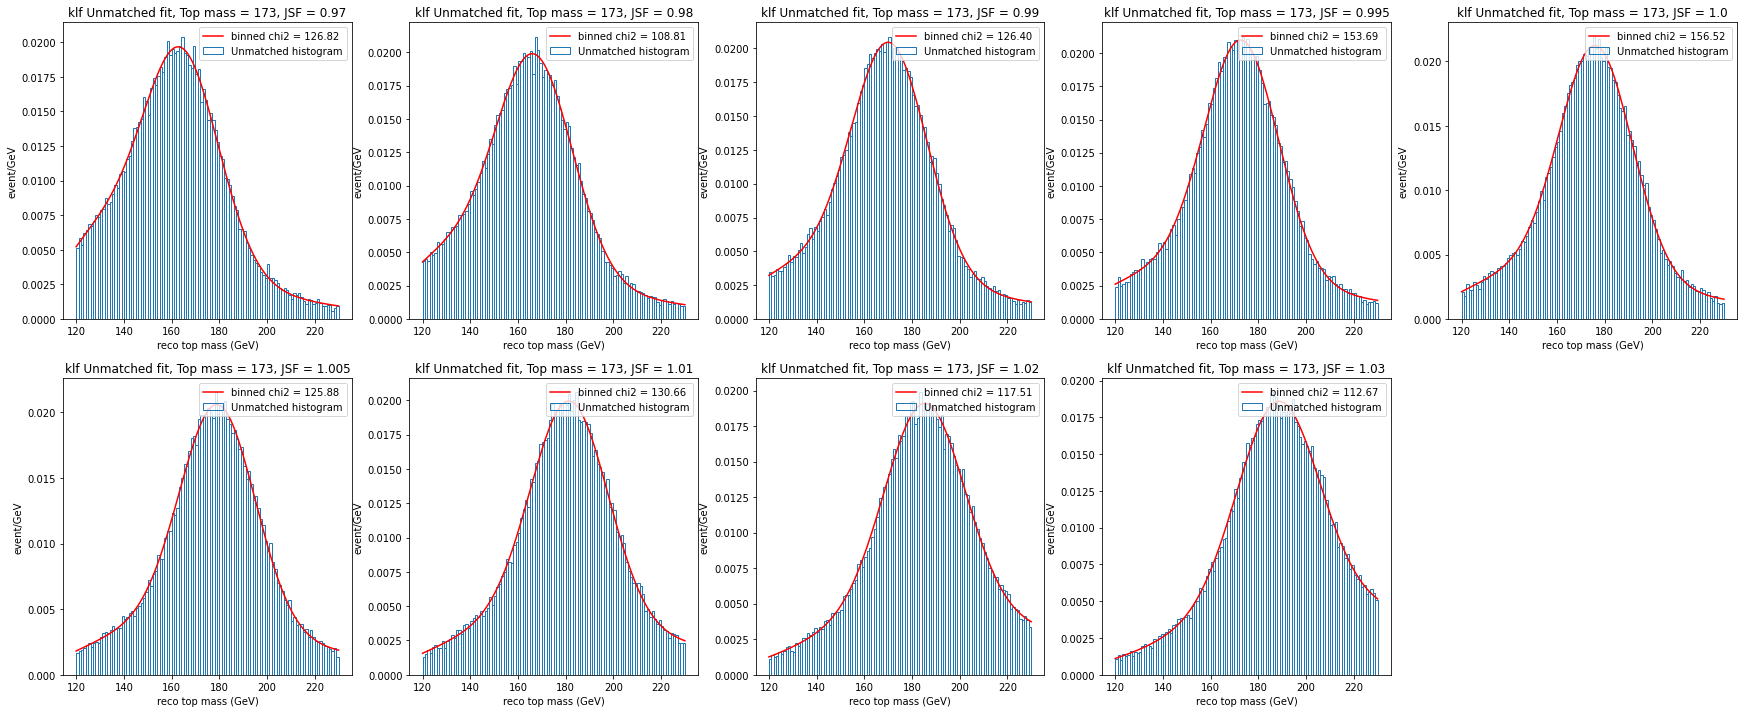

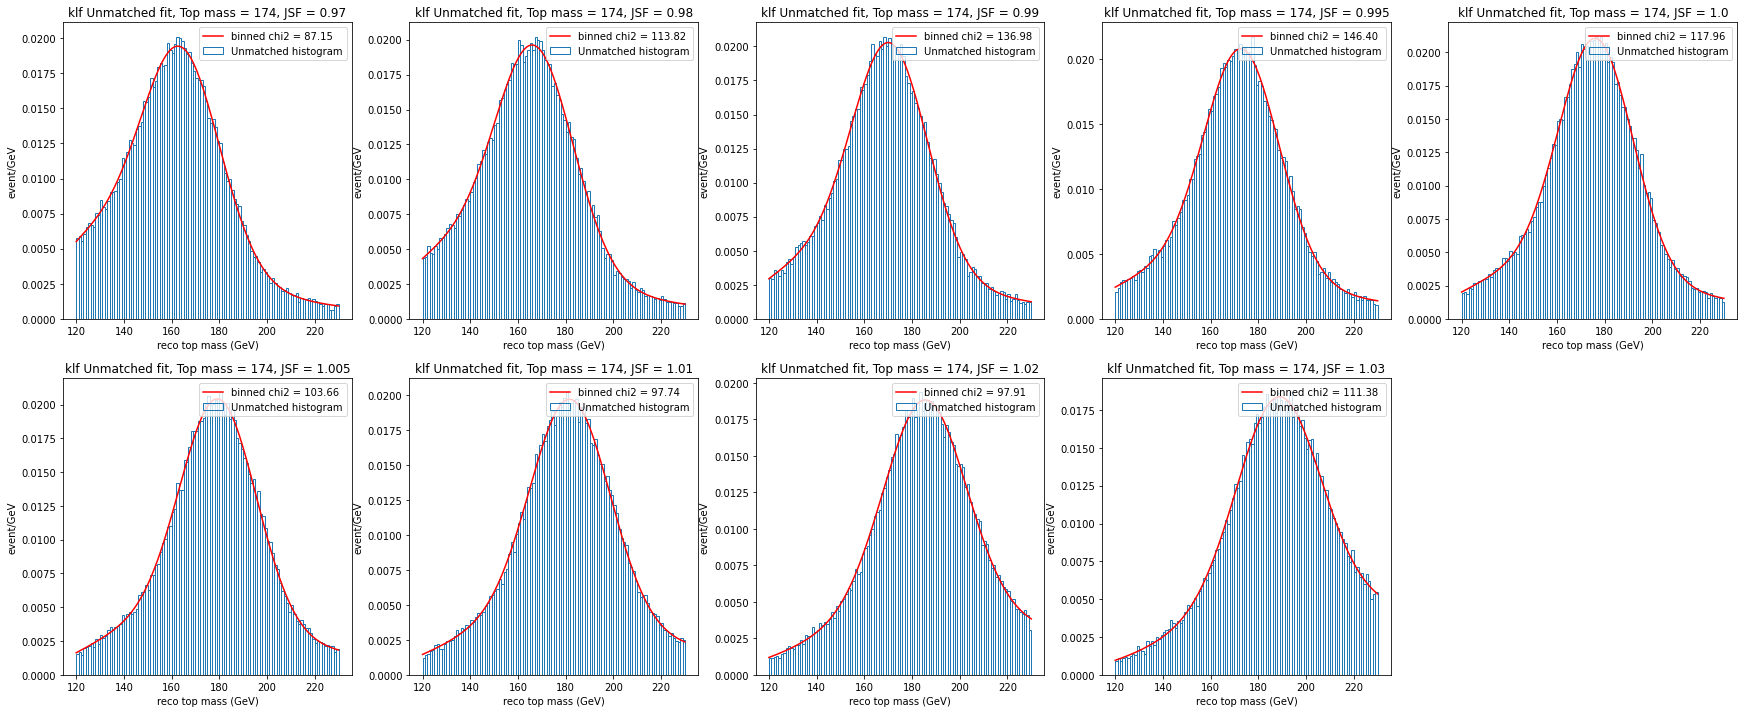

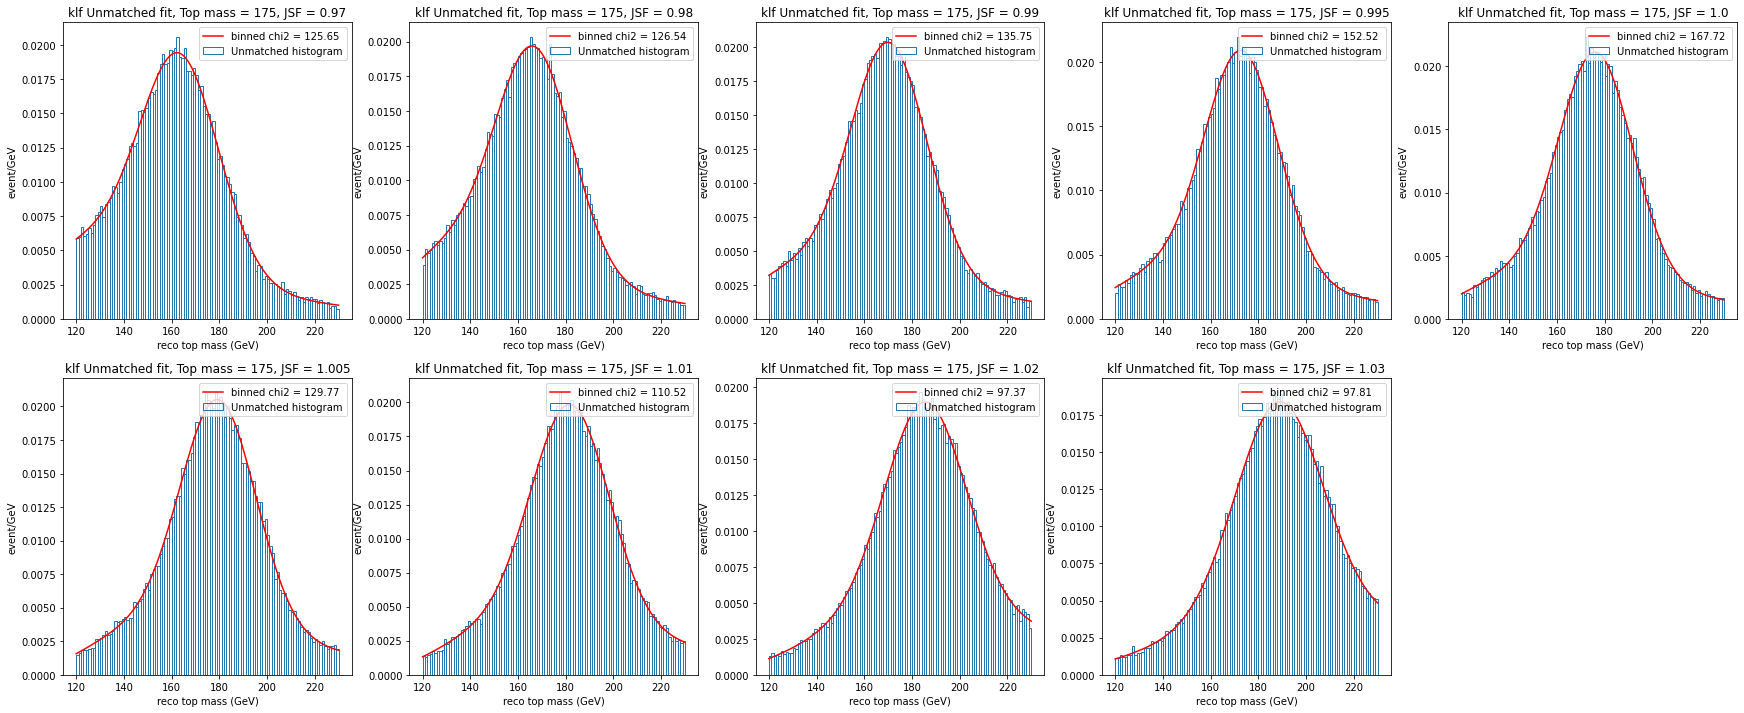

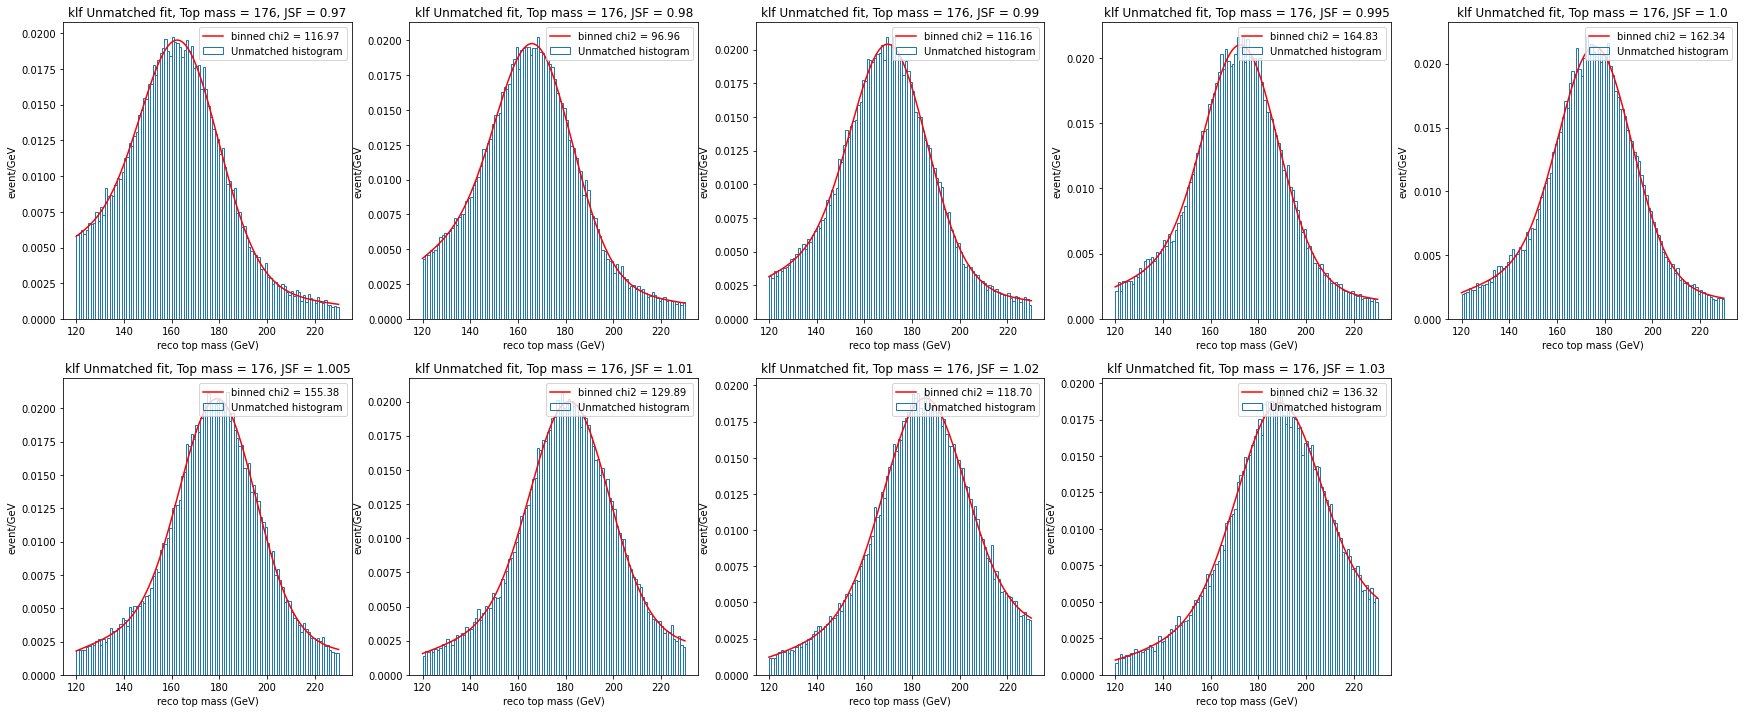

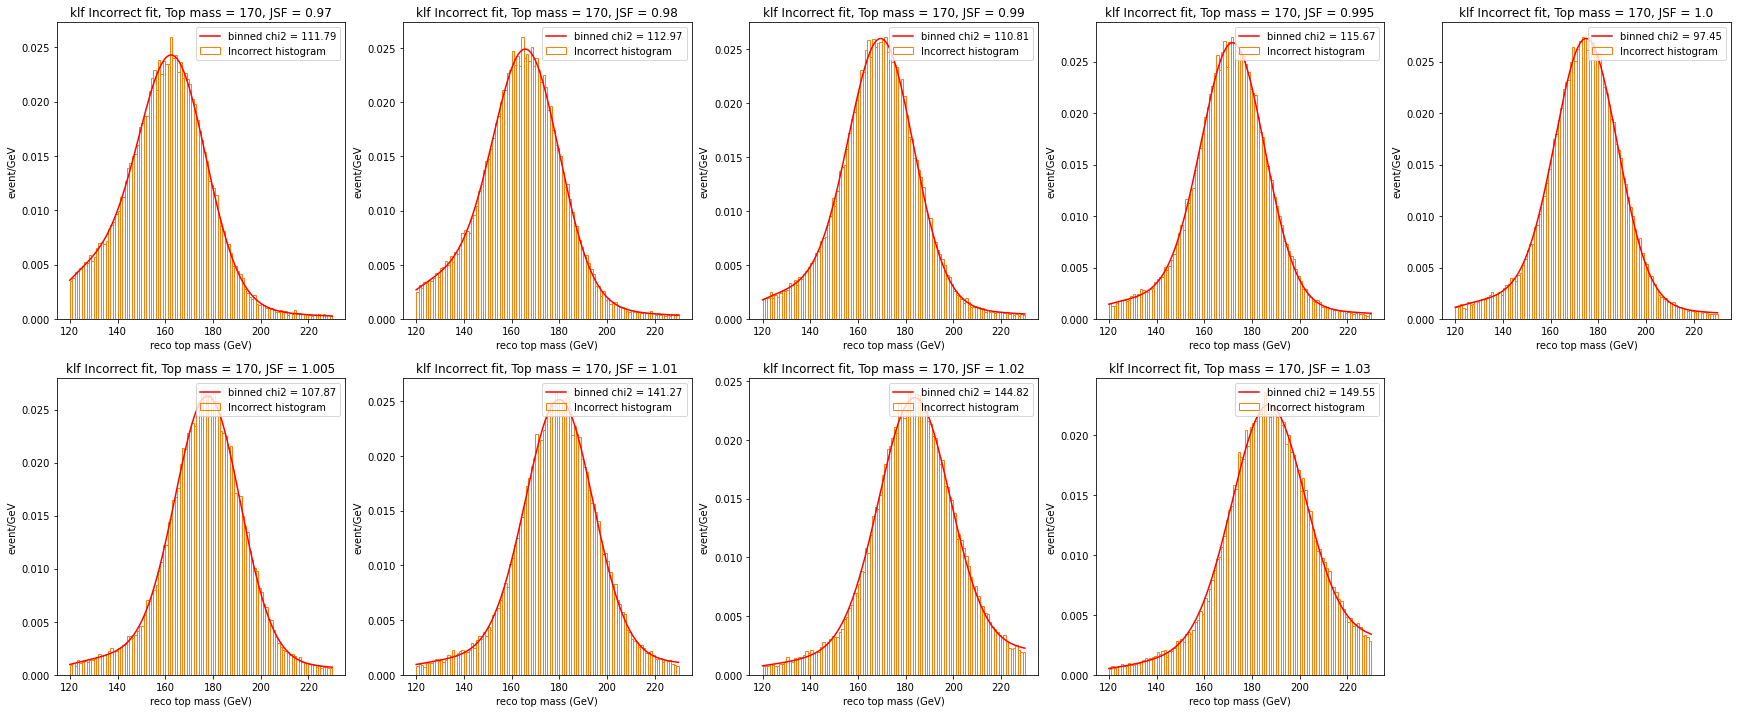

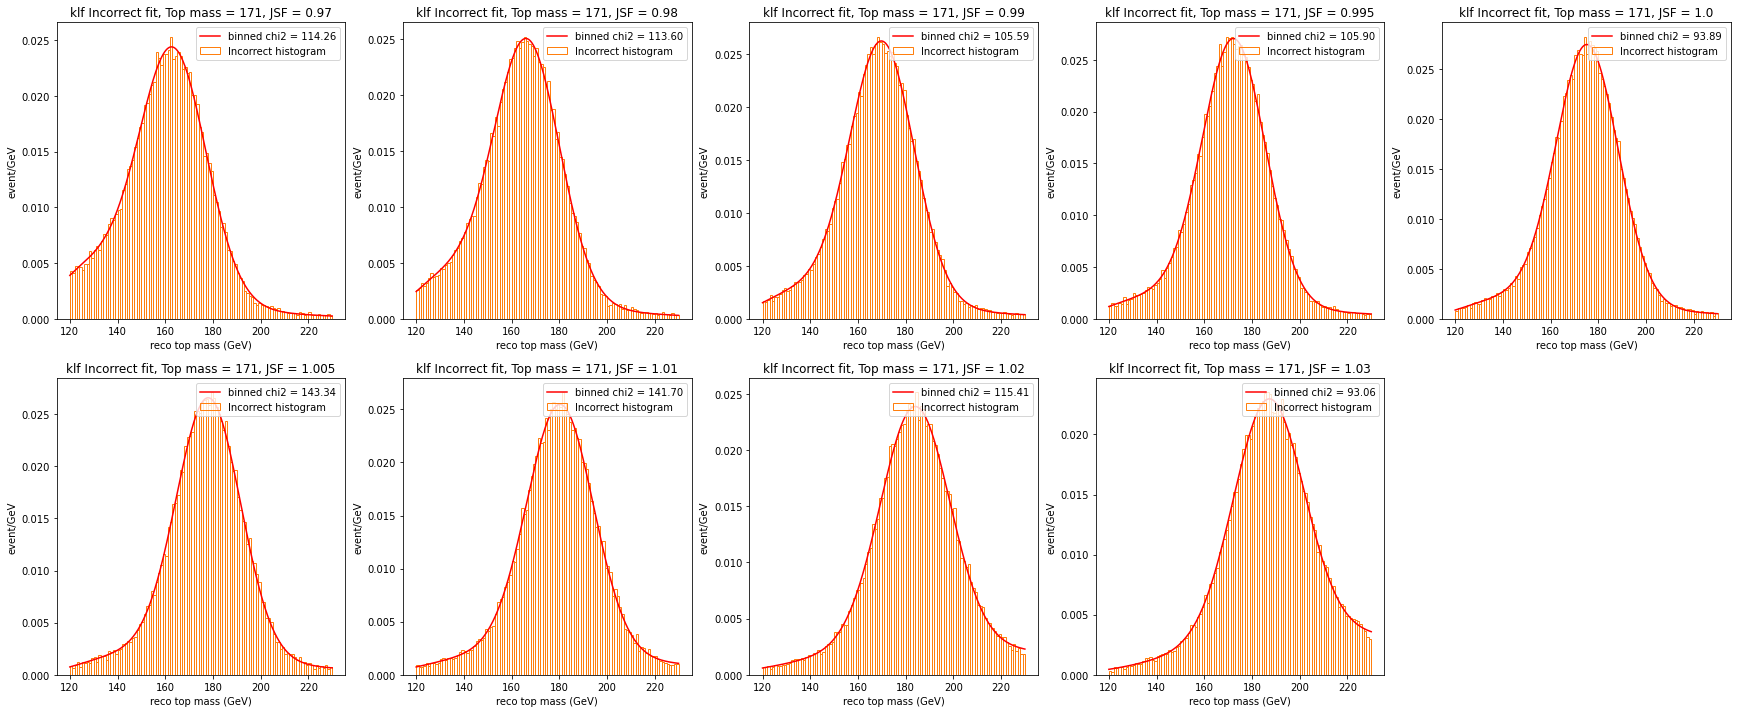

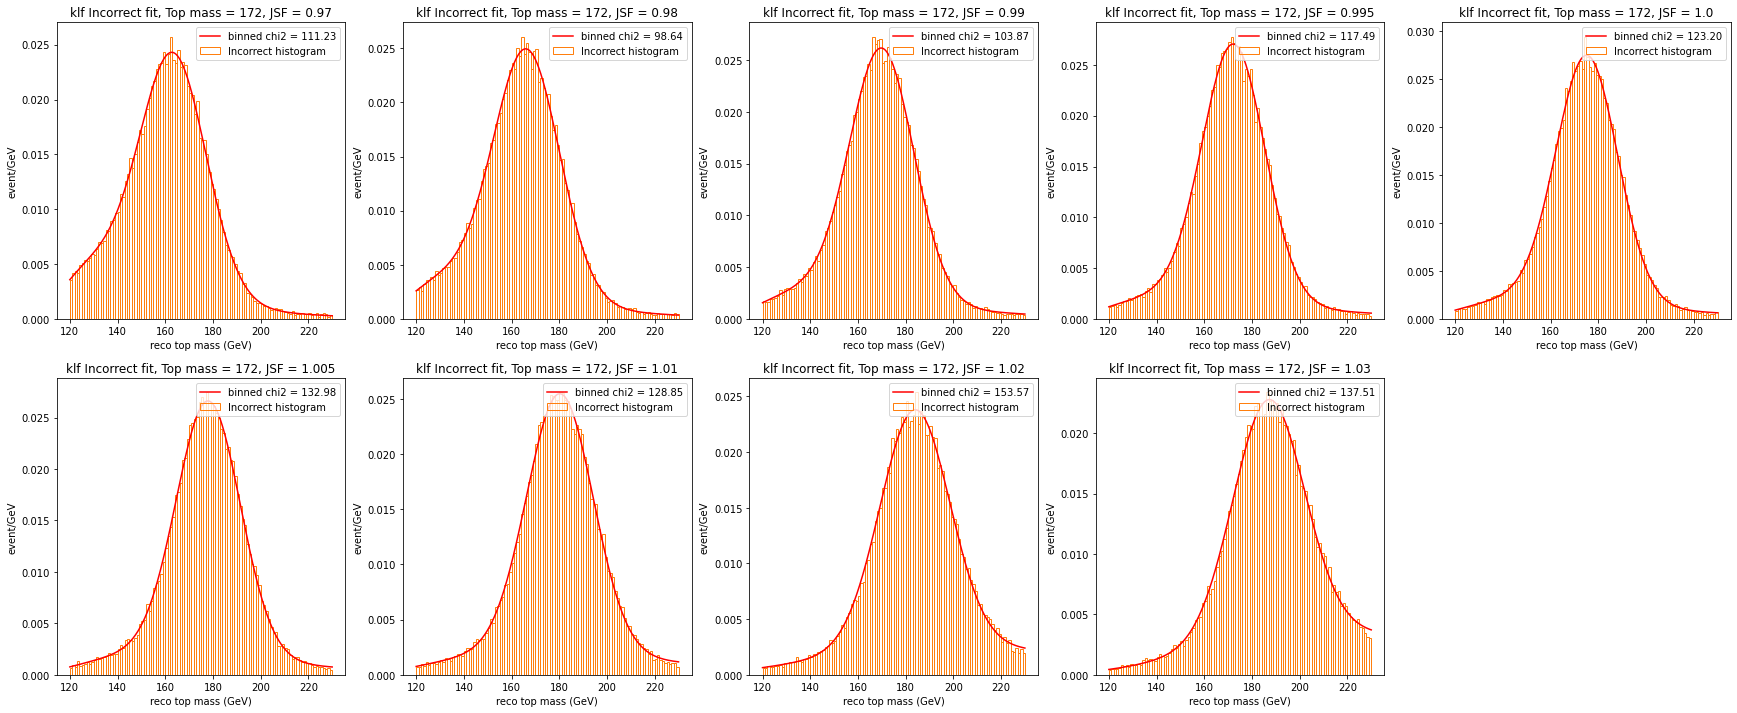

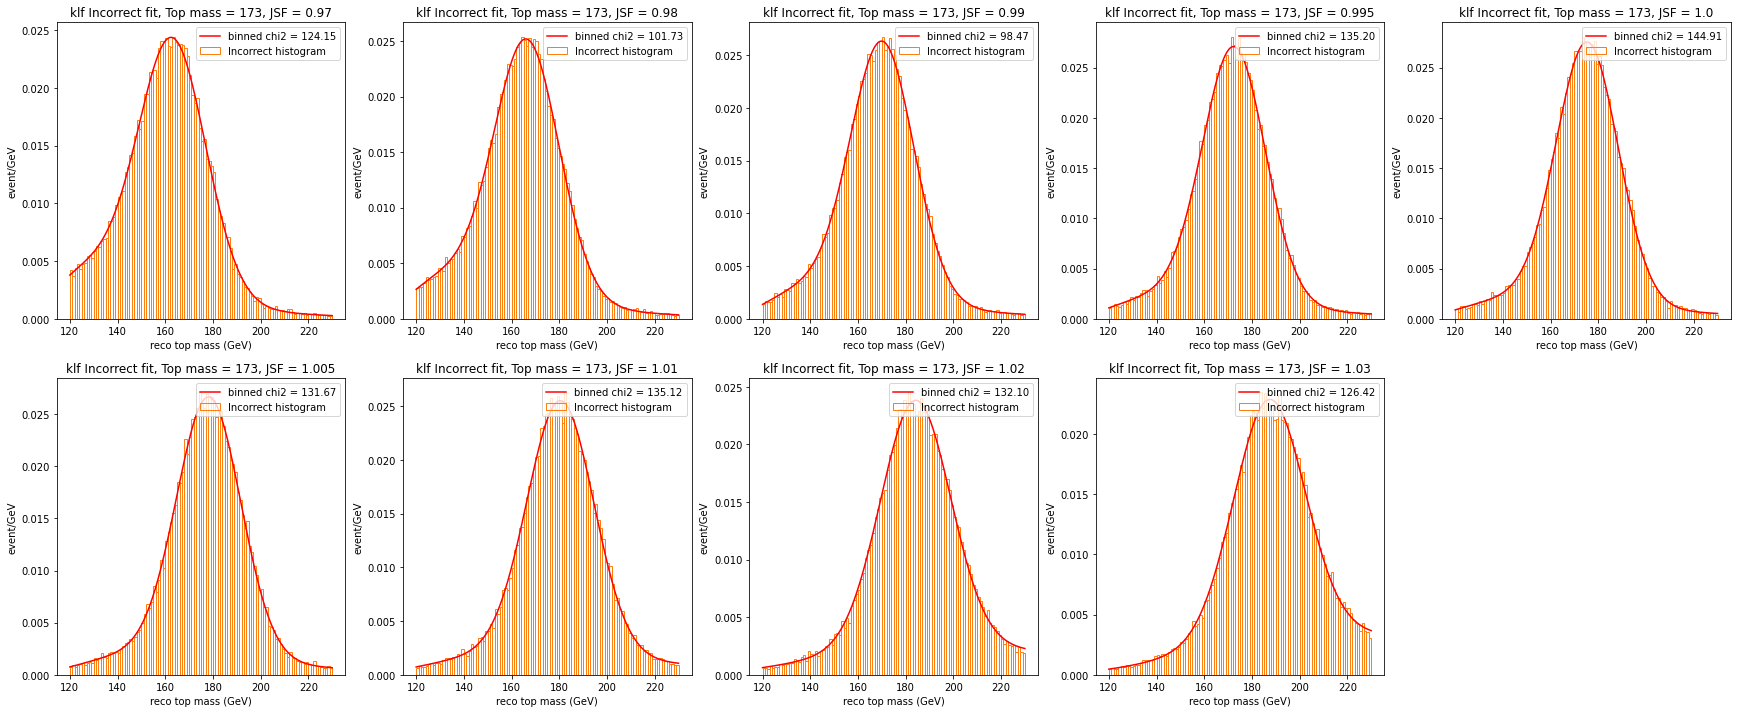

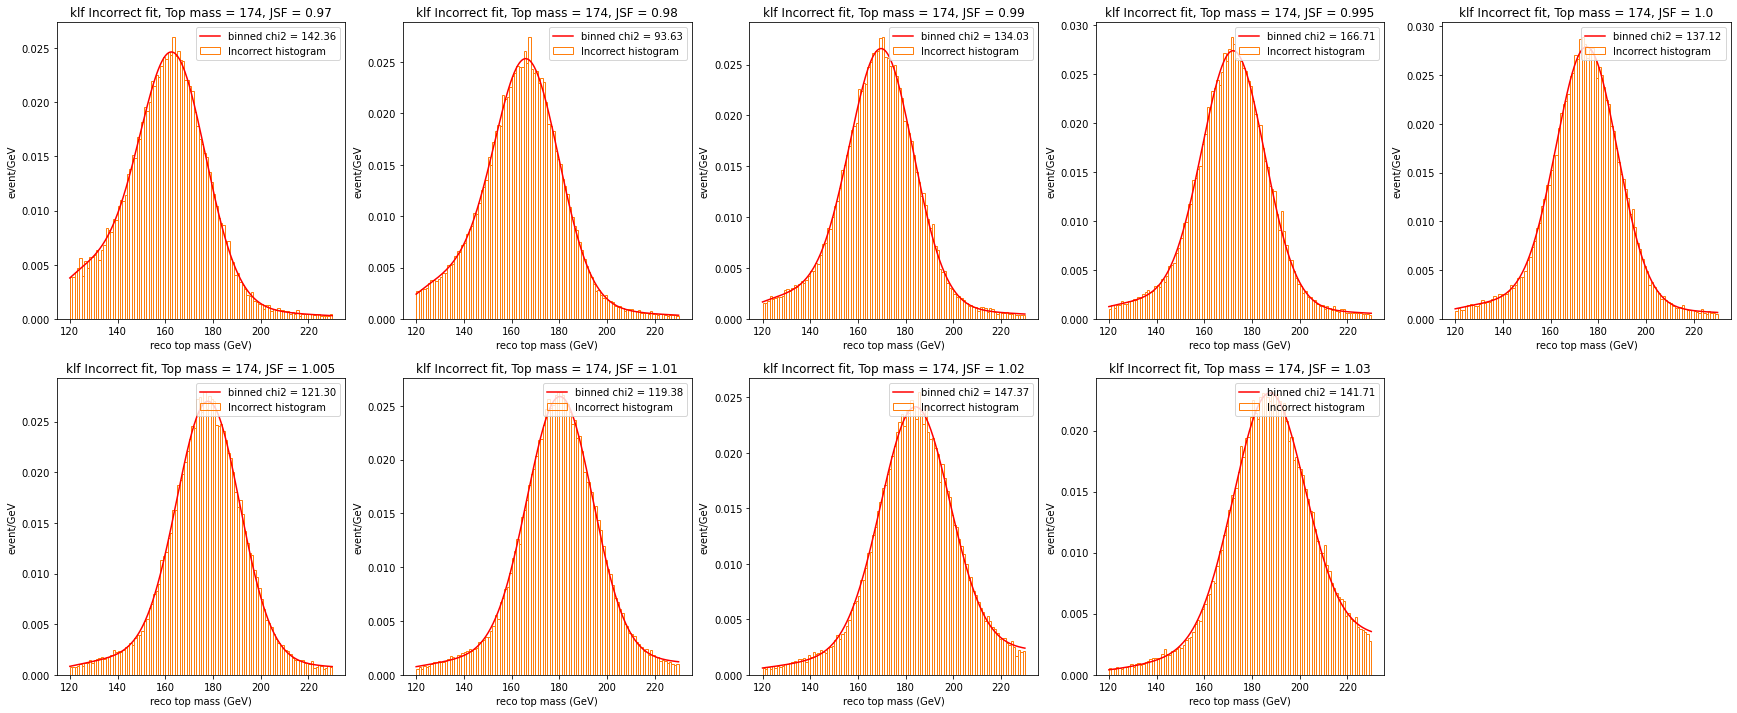

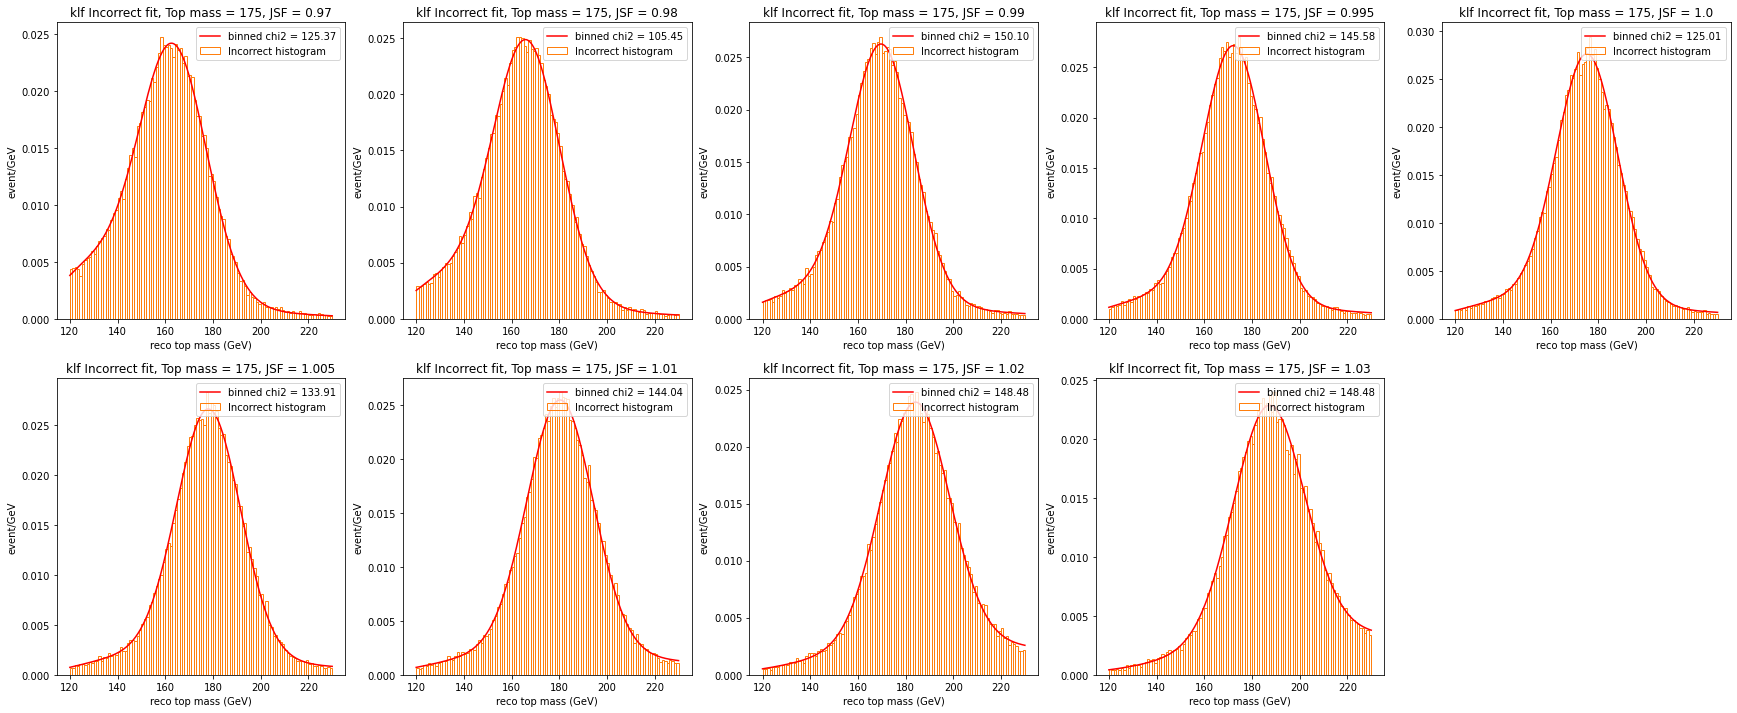

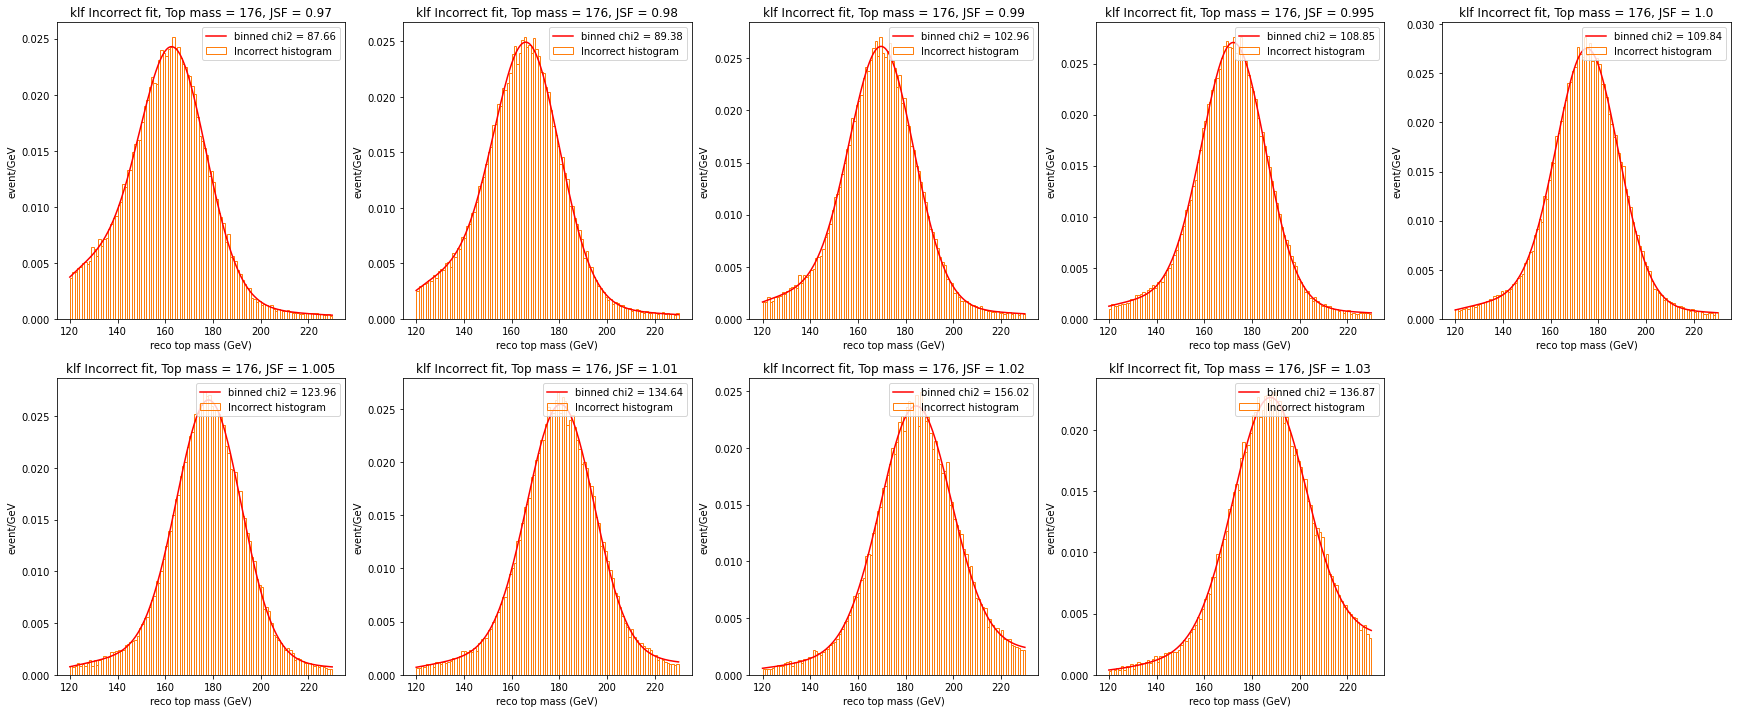

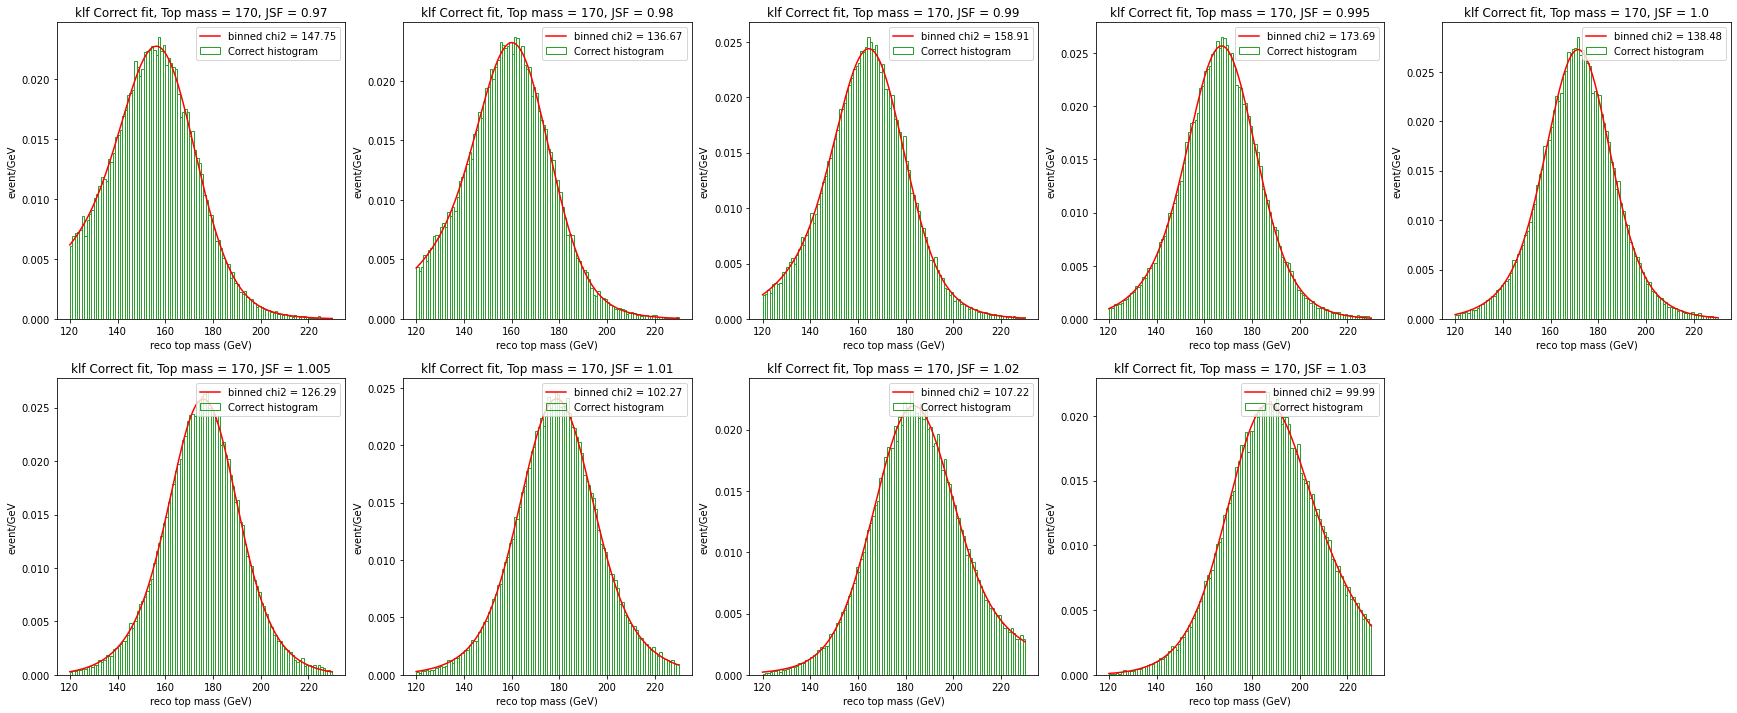

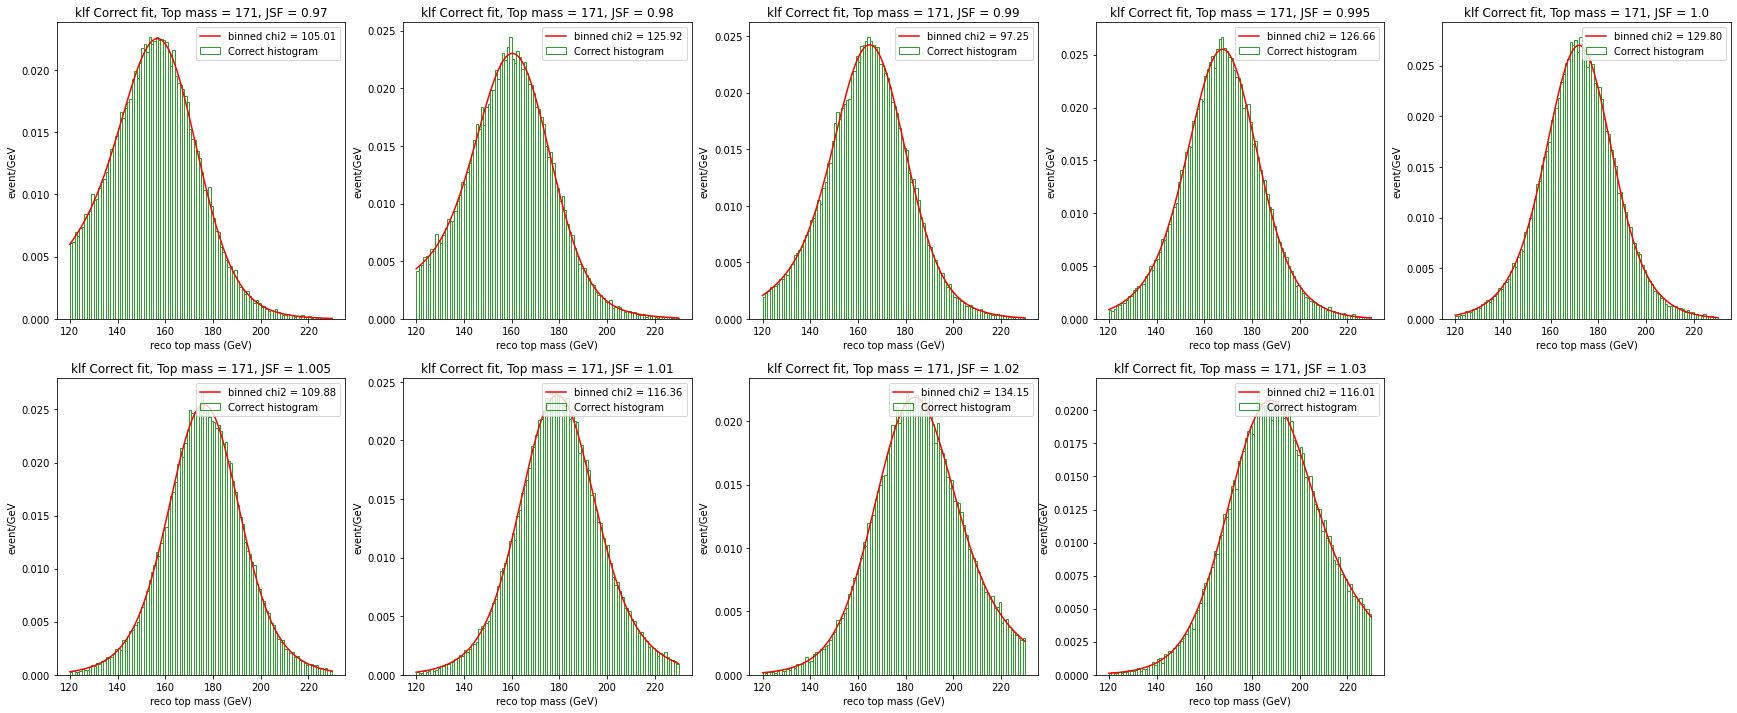

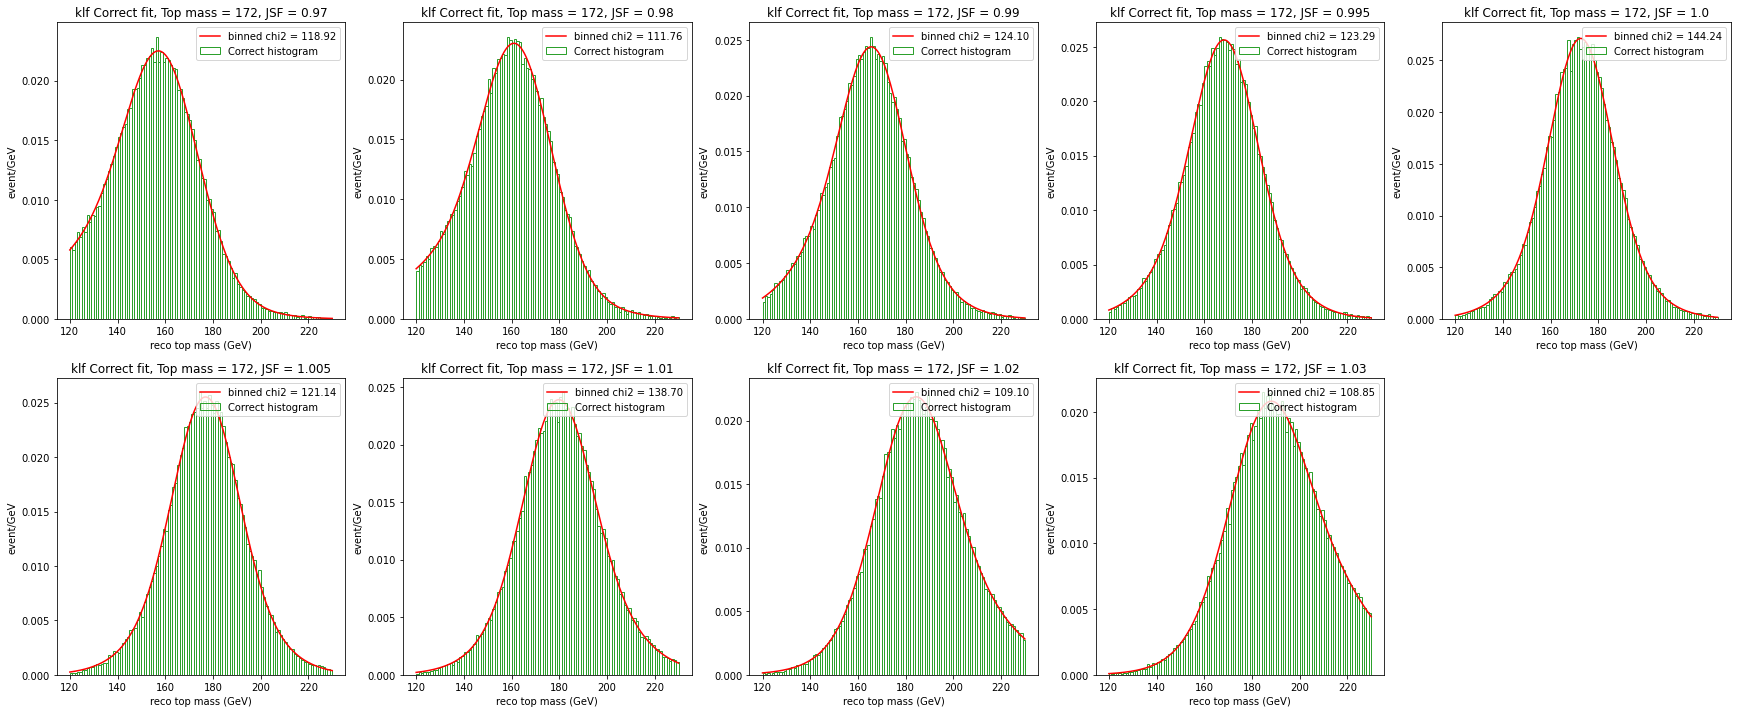

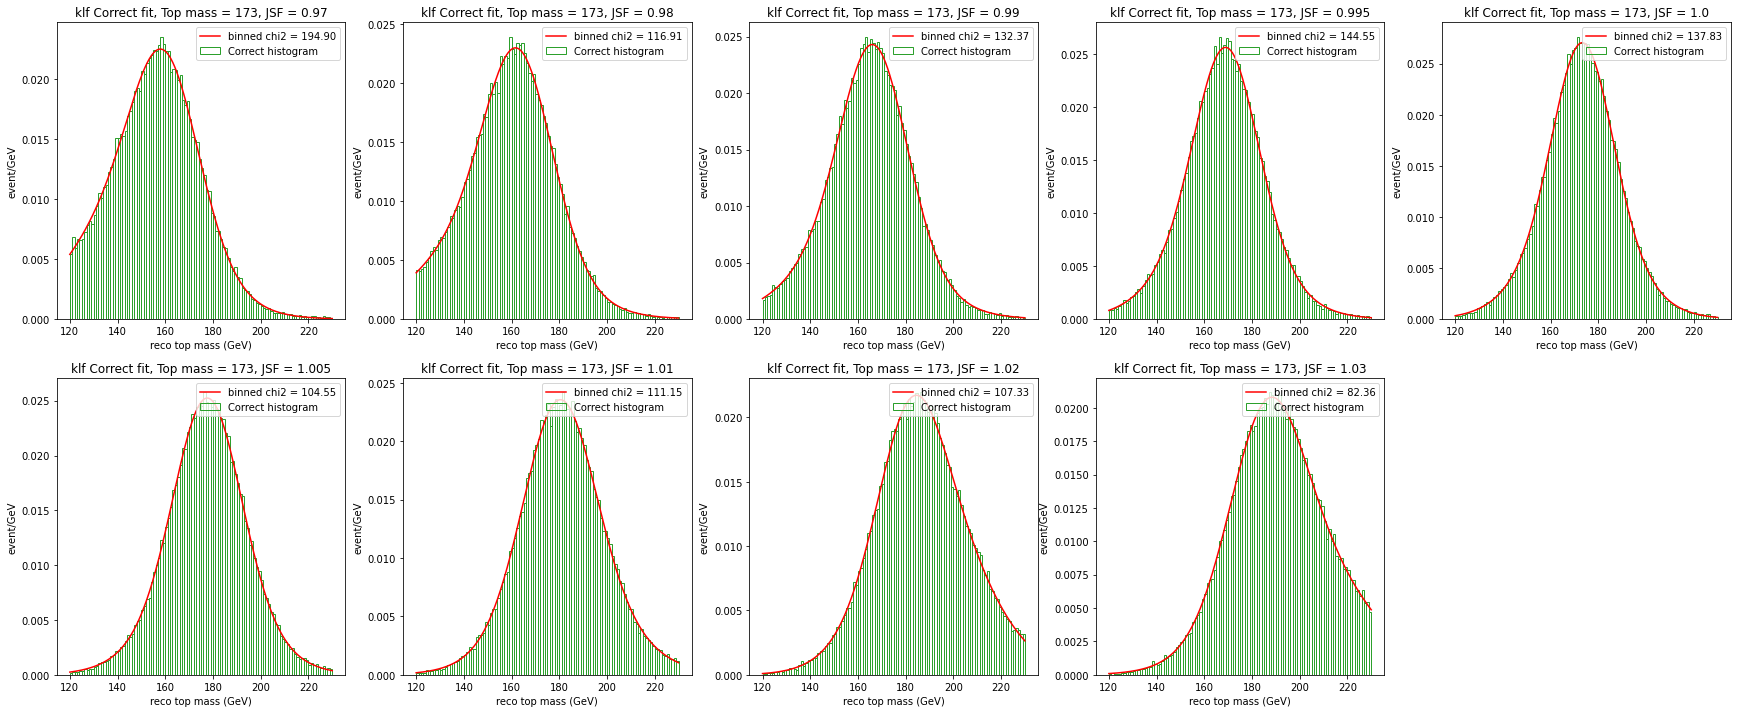

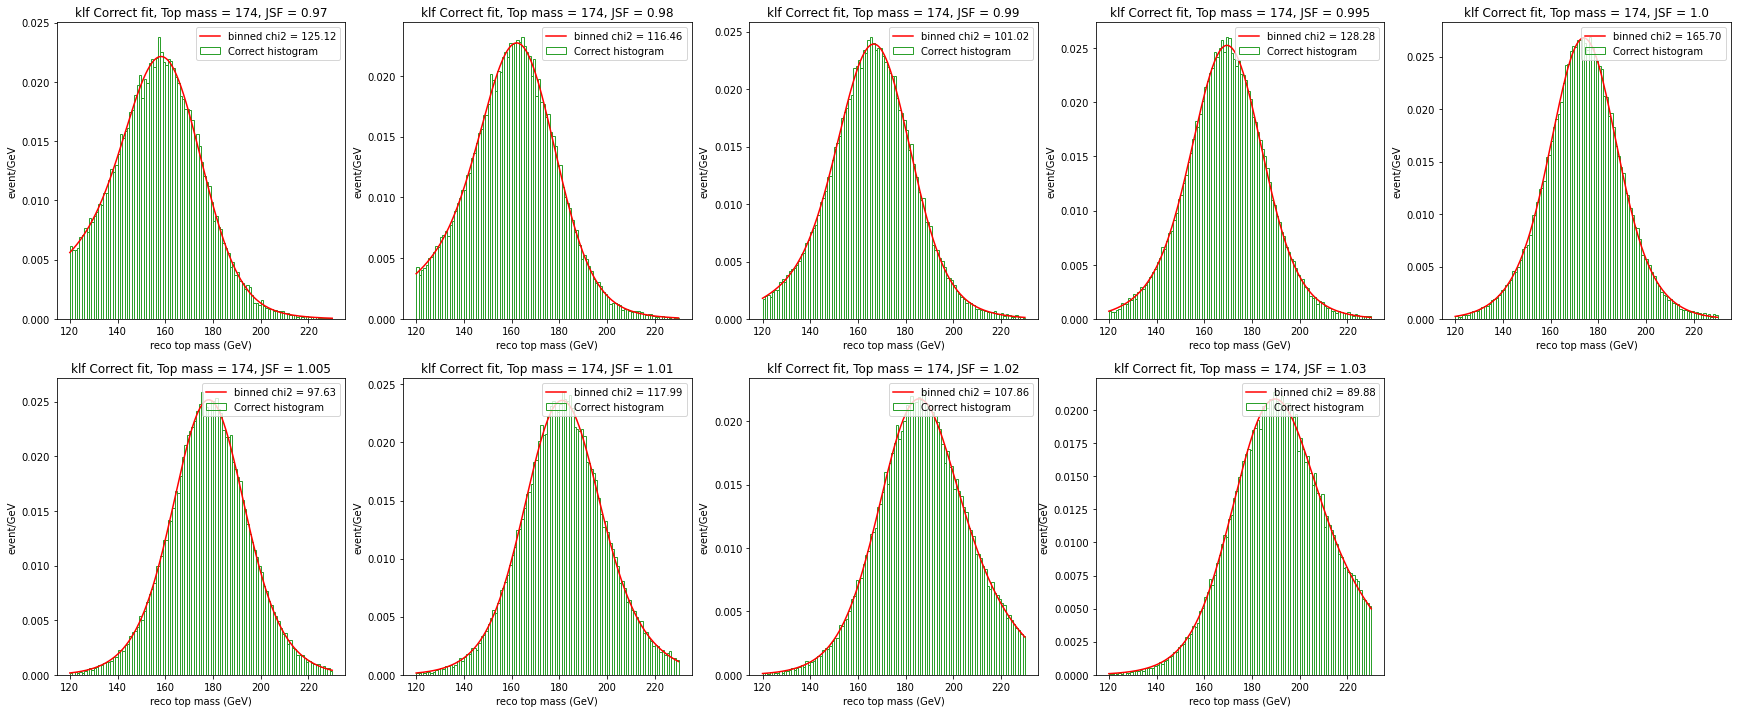

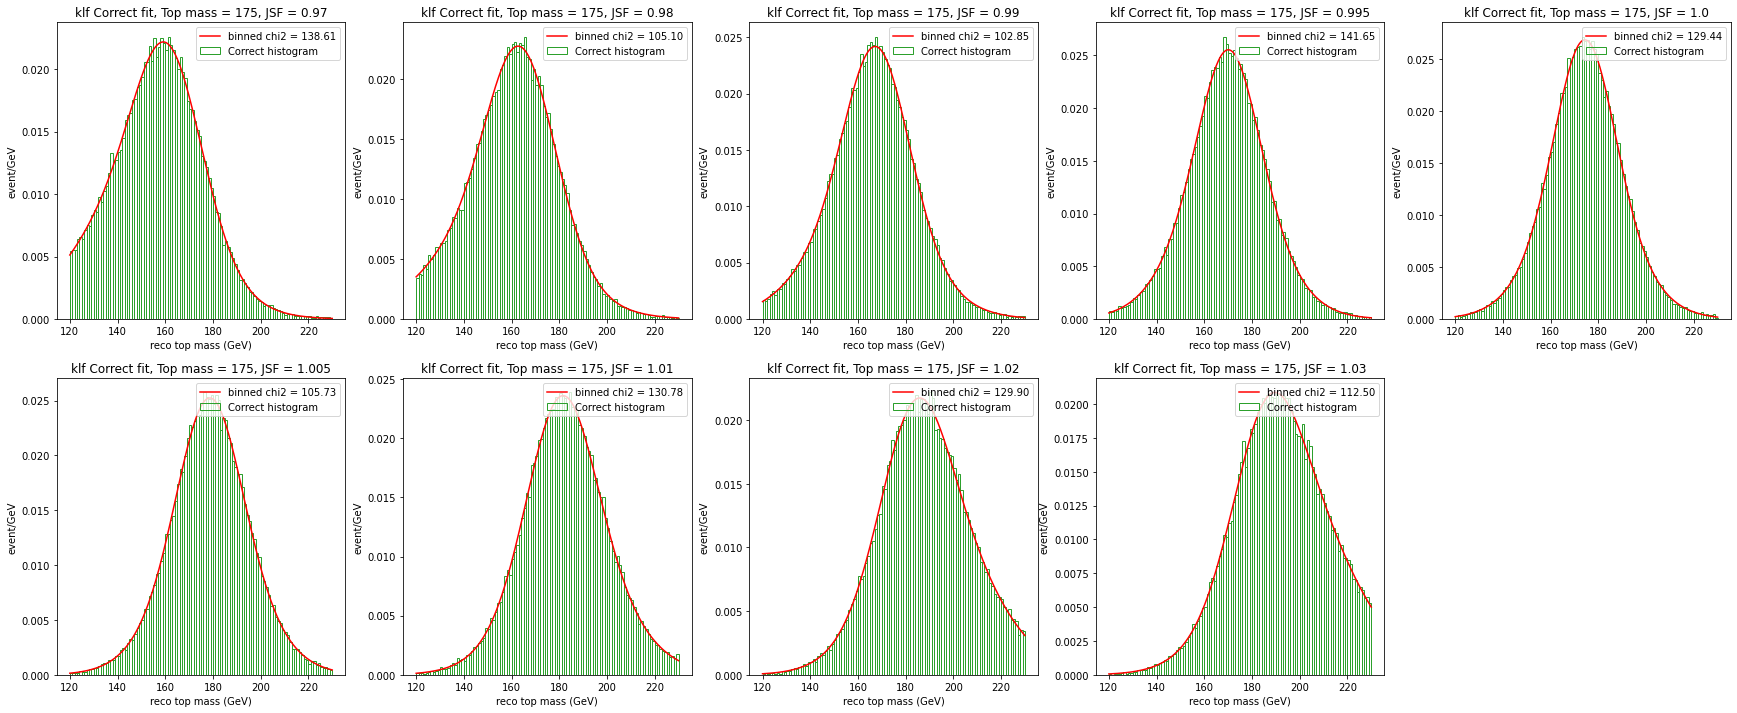

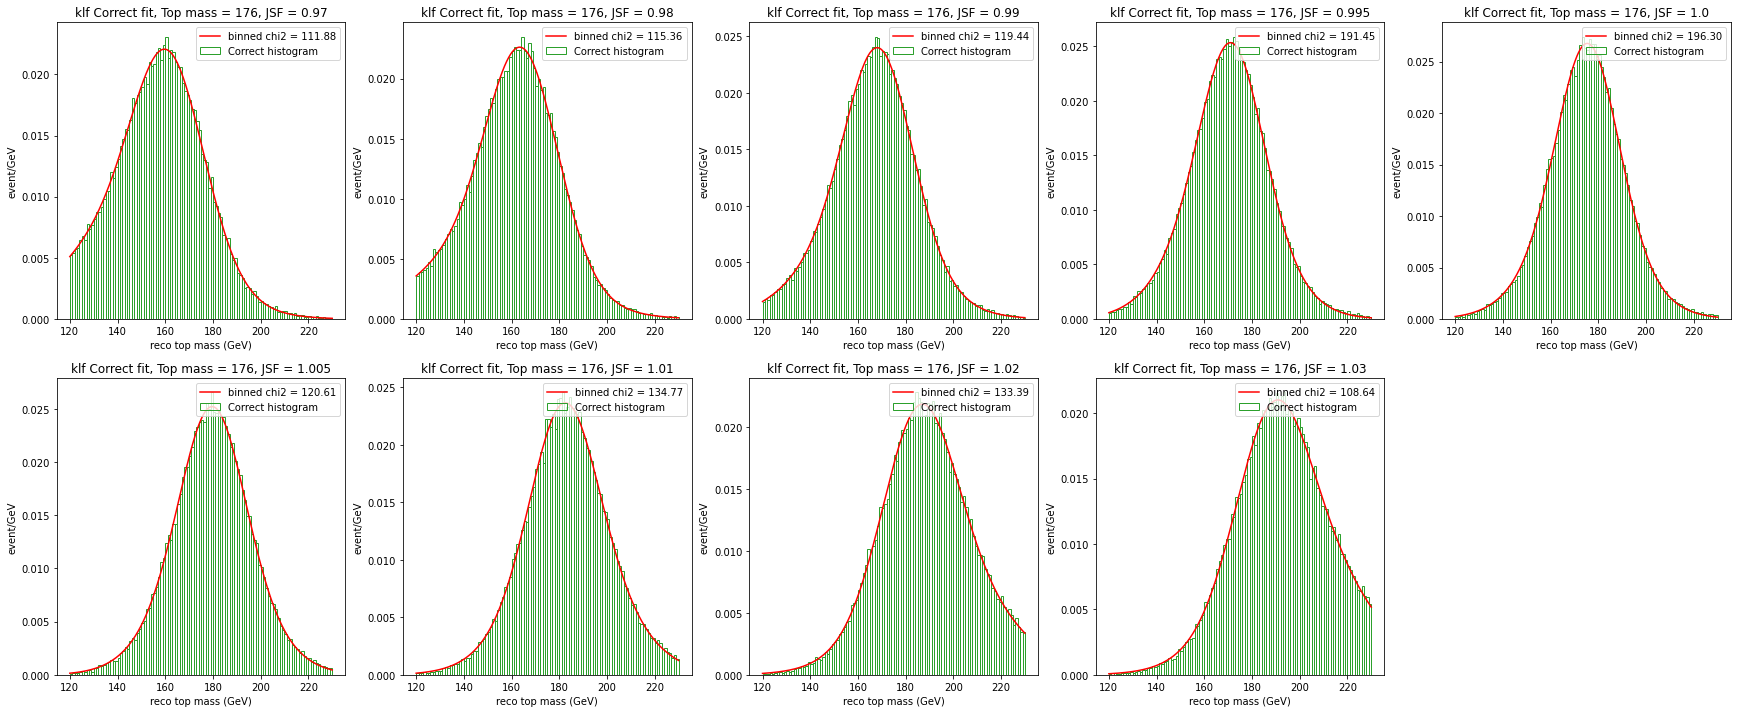

In [26]:
# Fit every klfitter class
fit_popt_dic = {i:{} for i in [0, 1, 2]}
fit_perr_dic = {i:{} for i in [0, 1, 2]}

for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=plt_fig)
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(plt_xn, plt_yn, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))]
            hist, _ = np.histogram(fit_target, bins=bins, density=True)
            # 2Gaussian for correct
            if state_i == 2:
                popt, pcov = optimize.curve_fit(two_gau_norm, bins[:-1]+bins_w/2, hist, p0=(180, 10, 170, 25, 0.9), bounds=((120, 5, 140, 18, 0), (200, 18, 200, 35, 1)))
                y_dense = two_gau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+bins_w/2, *popt))

            # Landau + Gaussian for incorrect and unmatch
            else:
                popt, pcov = optimize.curve_fit(langau_norm, bins[:-1]+bins_w/2, hist, p0=(150, 20, 160, 20, 0.9), bounds=((120, 10, 120, 10, 0), (220, 50, 220, 30, 1)))
                y_dense = langau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+bins_w/2, *popt))

            fit_popt_dic[state_i][(m, JSF)] = popt
            fit_perr_dic[state_i][(m, JSF)] = np.sqrt(np.diag(pcov))
            plt.bar(bins[:-1]+bins_w/2, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
            plt.title('klf {} fit, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc='upper right')
        plt.show()

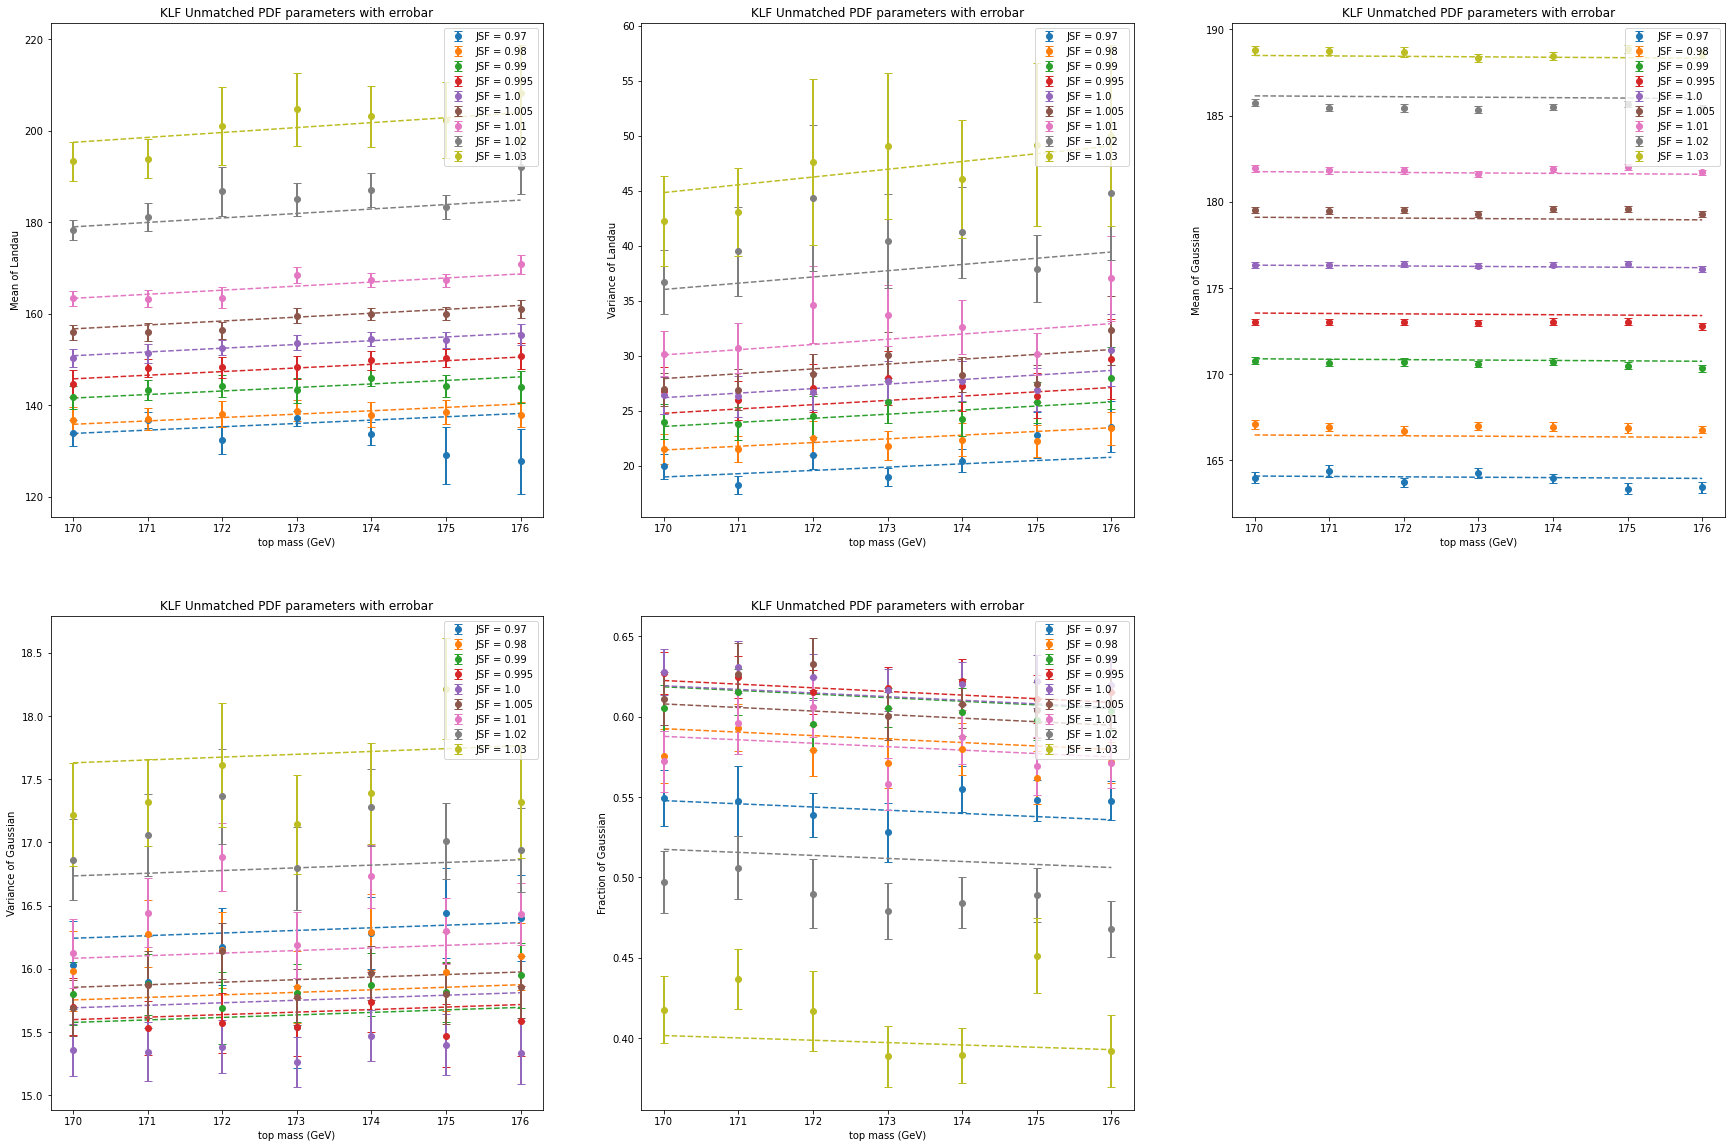

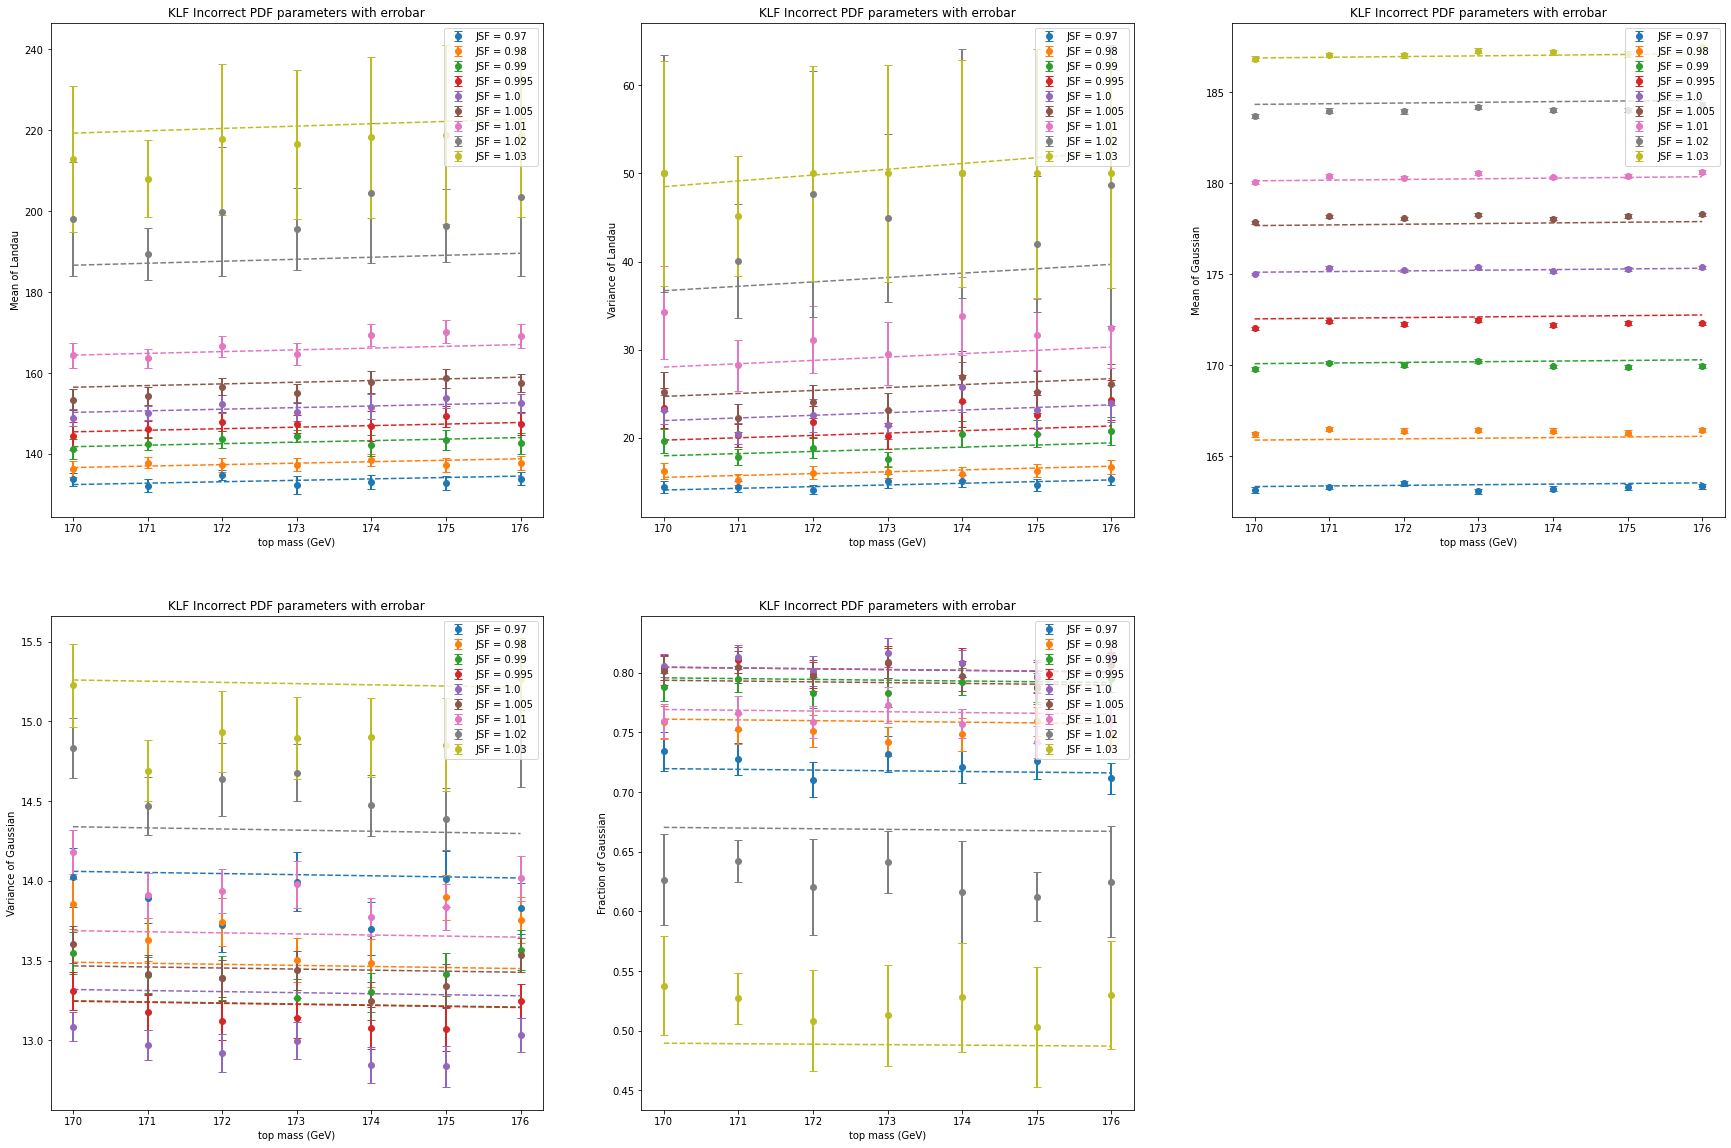

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


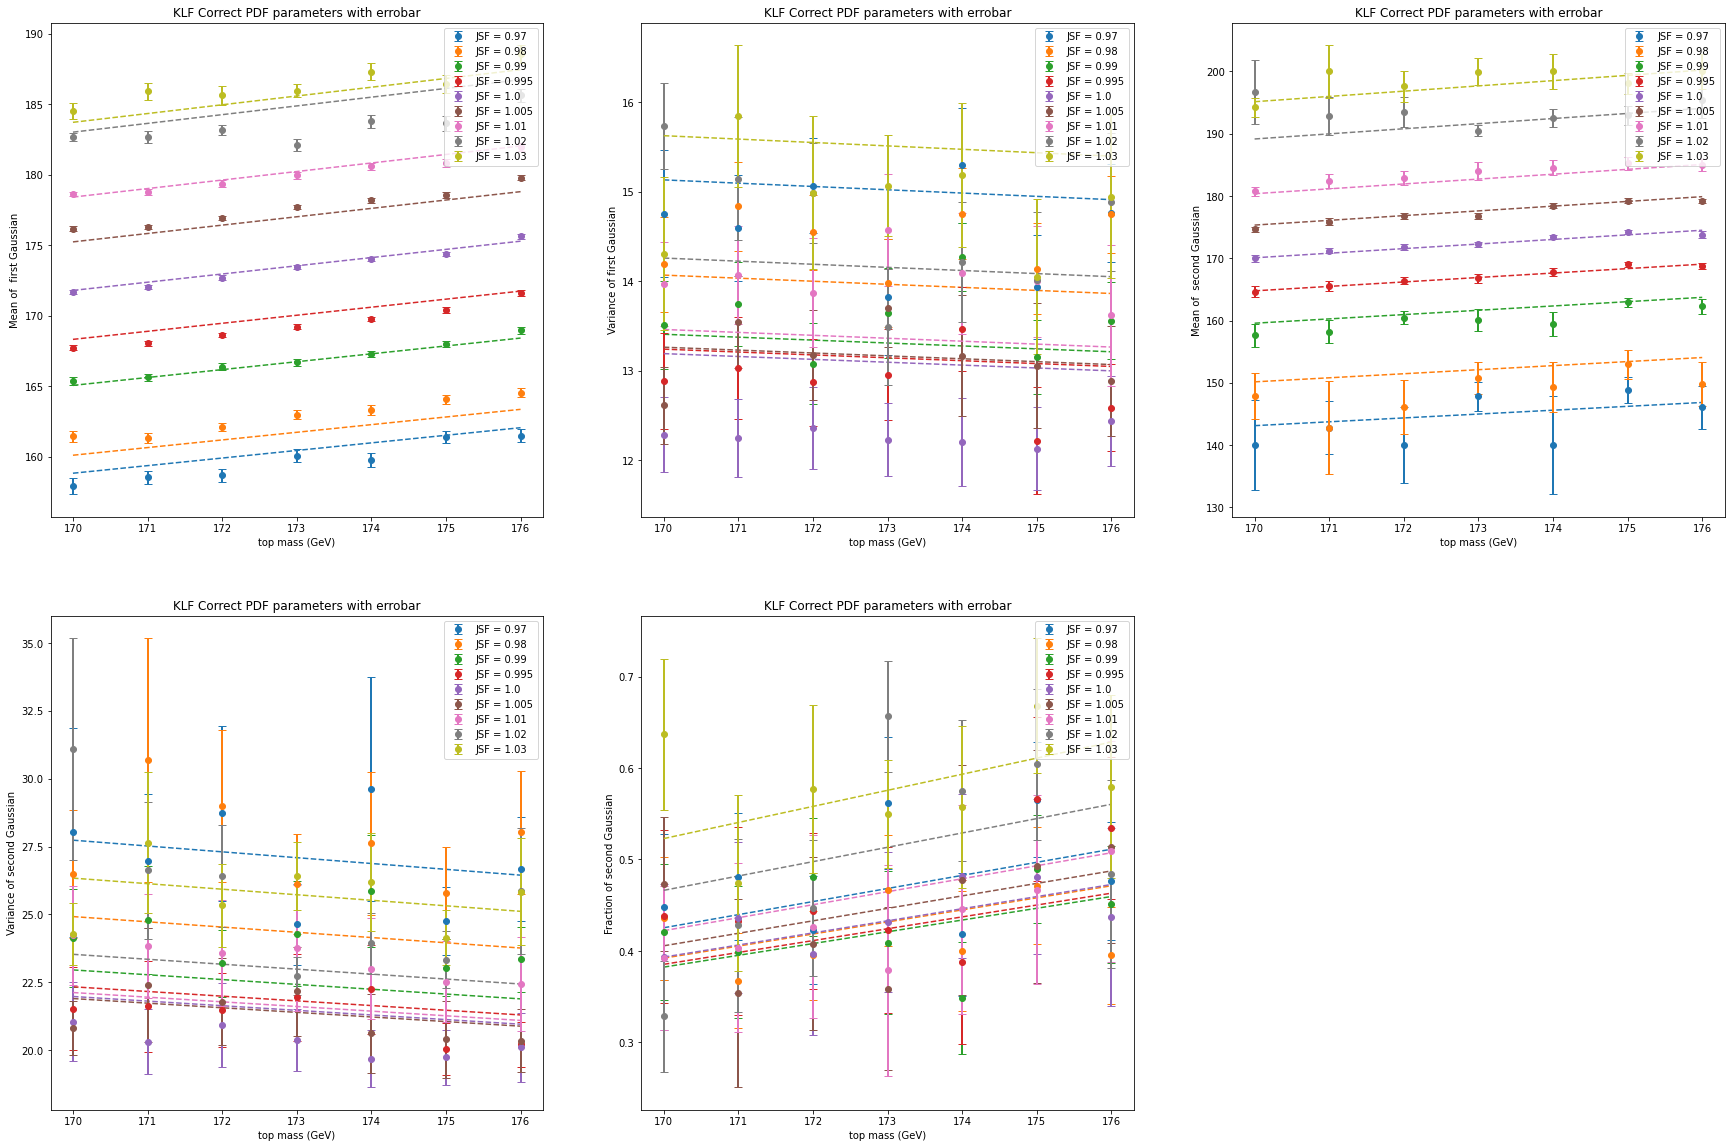

In [27]:
pdf_klf_dic = defaultdict(list)
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_fourth, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_dic[(state_i, i)] = popt

        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label='JSF = {}'.format(JSF), c=colors[j])
            plt.plot(top_mass_dense, linear_fourth([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('KLF {} PDF parameters with errobar'.format(state_labels[state_i]))
        plt.xlabel('top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
    plt.show()

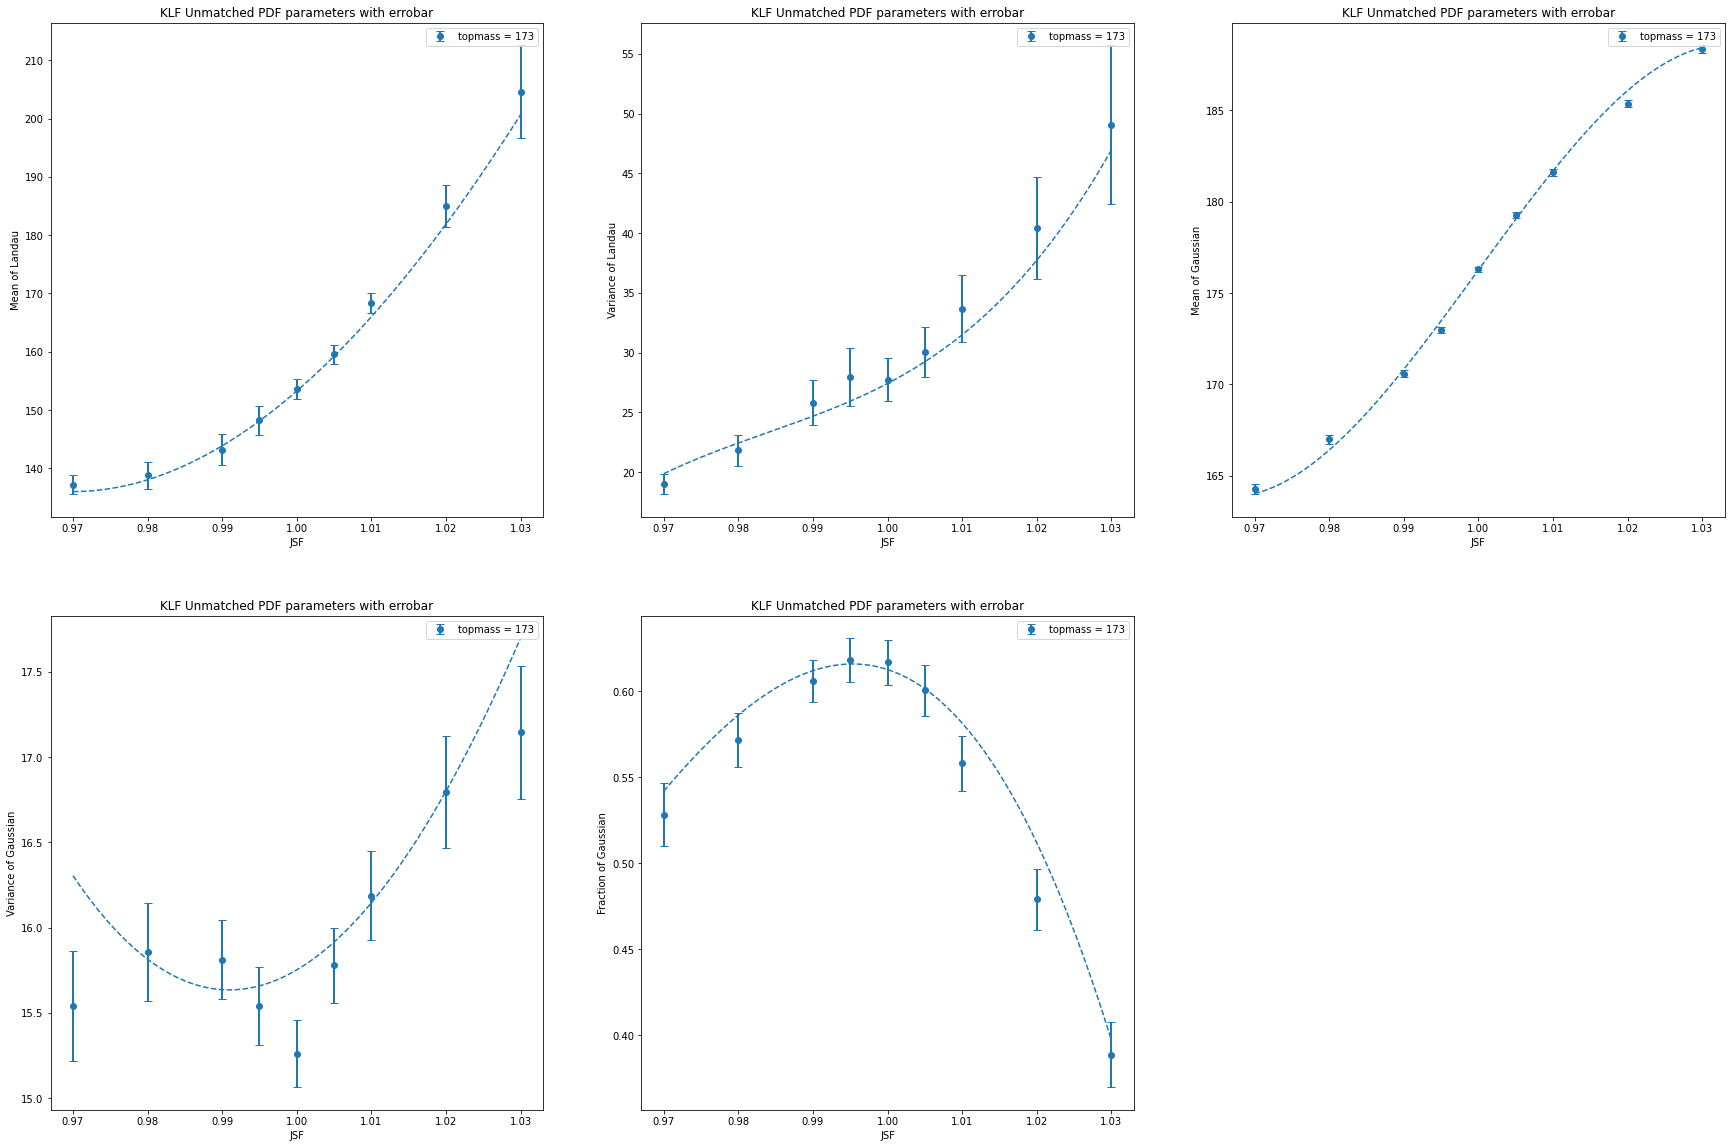

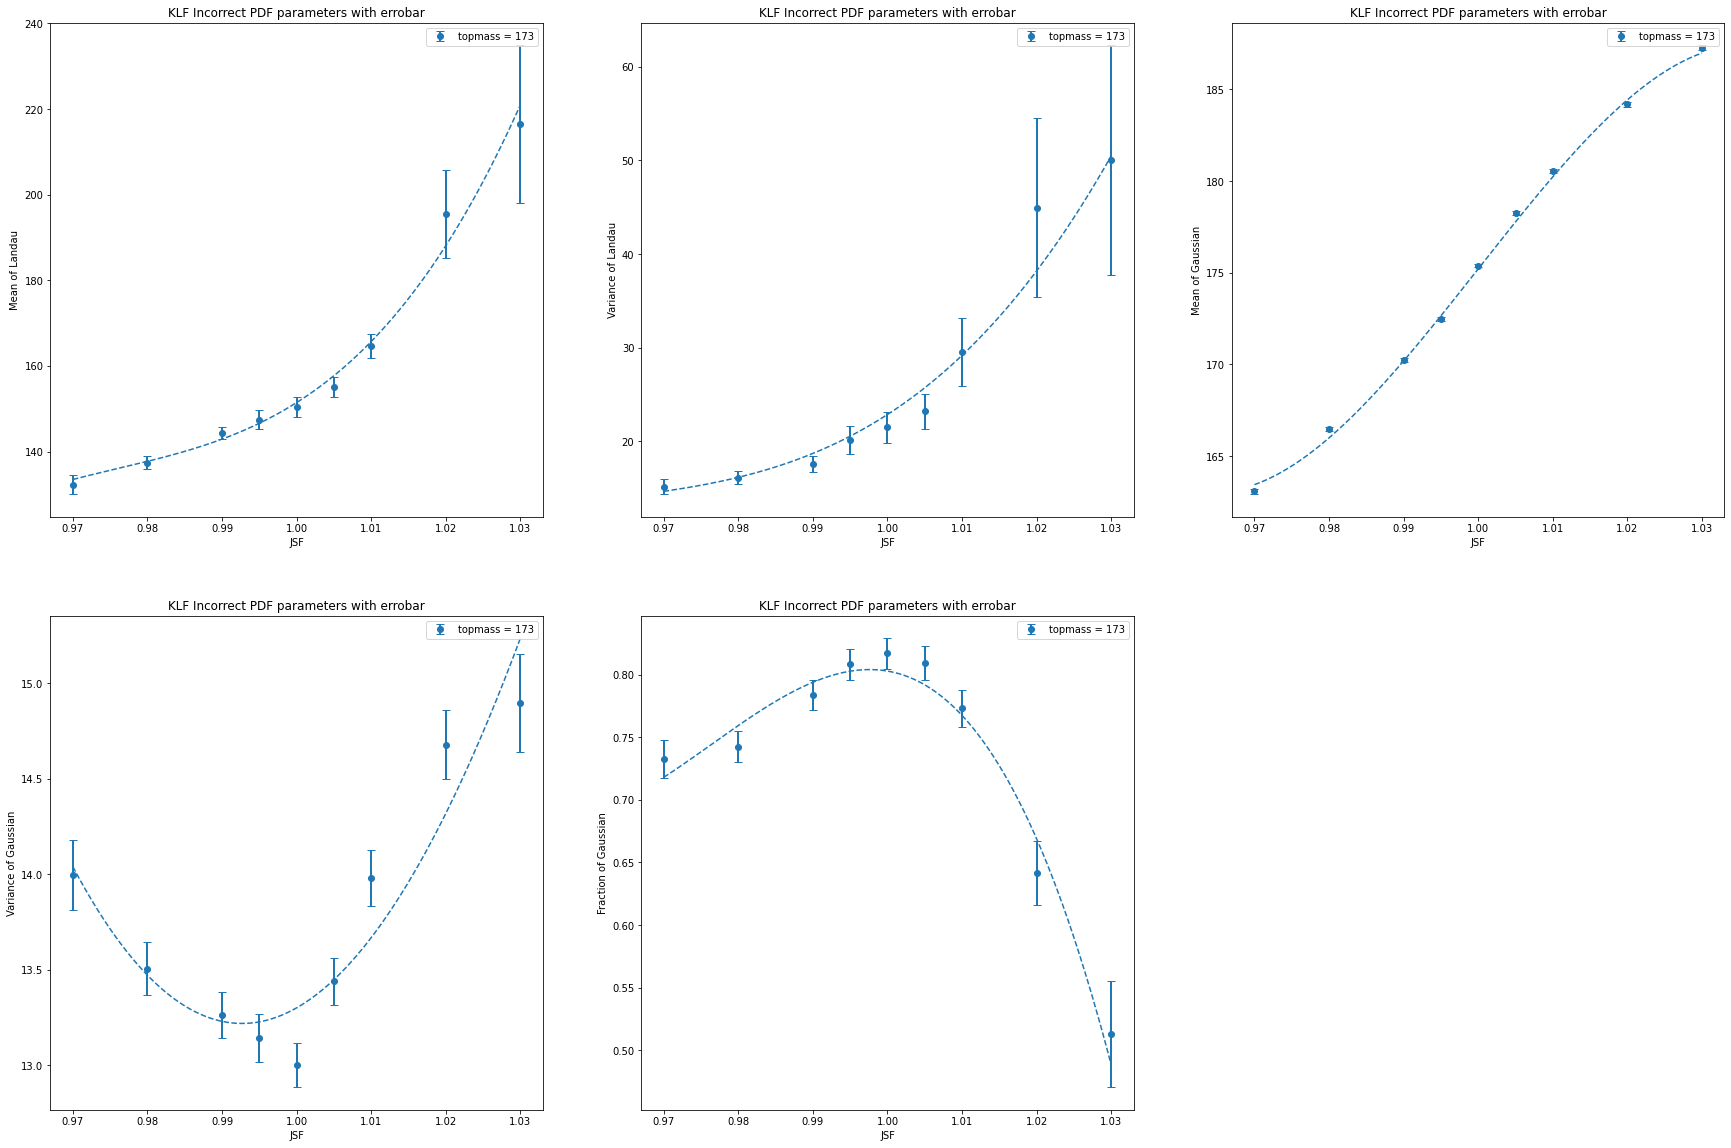

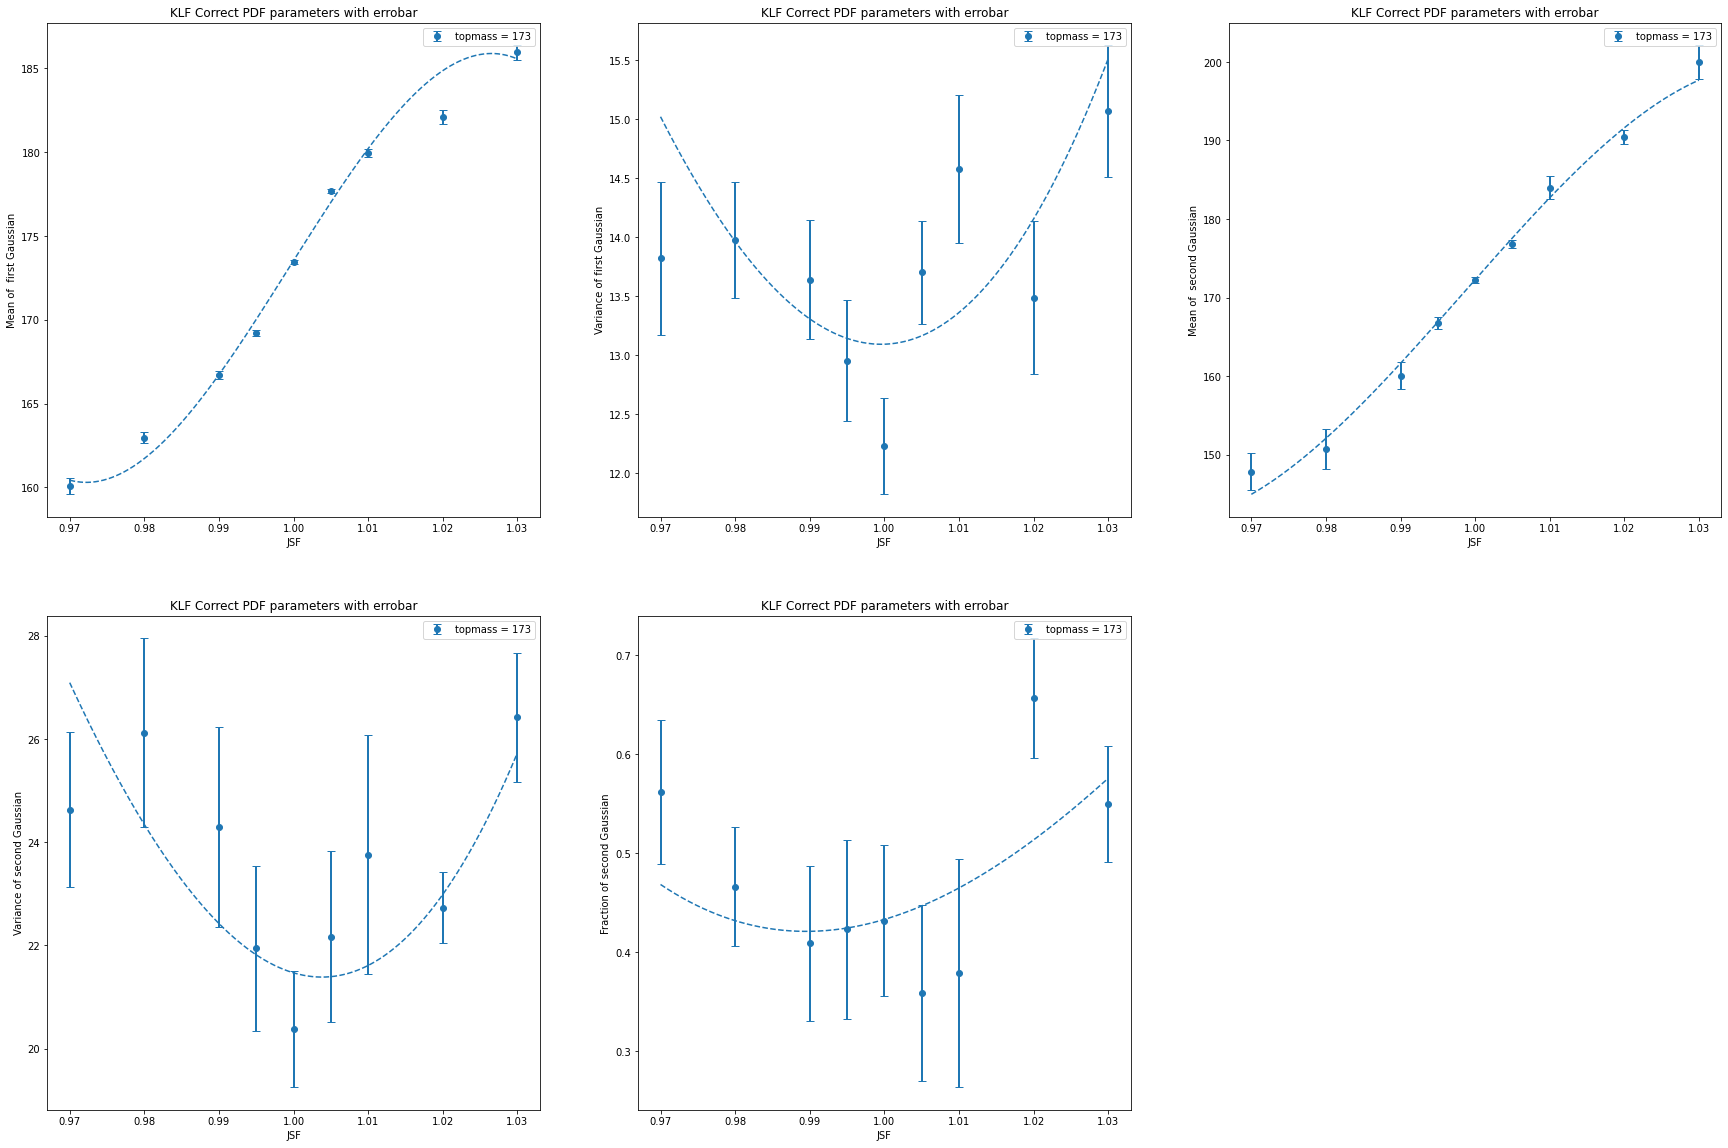

In [28]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_fourth, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")

        for j, m in enumerate([173]):
            plt.errorbar(JSF_arr, [fit_popt_dic[state_i][(m, JSF)][i] for JSF in JSF_arr], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for JSF in JSF_arr], fmt='o', elinewidth=2, capsize=4, label='topmass = {}'.format(m), c=colors[j])
            plt.plot(JSF_dense, linear_fourth([np.array([m]*1000), JSF_dense], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('KLF {} PDF parameters with errobar'.format(state_labels[state_i]))
        plt.xlabel('JSF')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
    plt.show()

In [ ]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_fourth, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")

        for j, m in enumerate(mass):
            plt.errorbar(JSF_arr, [fit_popt_dic[state_i][(m, JSF)][i] for JSF in JSF_arr], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for JSF in JSF_arr], fmt='o', elinewidth=2, capsize=4, label='topmass = {}'.format(m), c=colors[j])
            plt.plot(JSF_dense, linear_fourth([np.array([m]*1000), JSF_dense], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('KLF {} PDF parameters with errobar'.format(state_labels[state_i]))
        plt.xlabel('top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
    plt.show()

In [ ]:
# Fit every spanet class
fit_popt_dic = {i:{} for i in [0, 1, 2]}
fit_perr_dic = {i:{} for i in [0, 1, 2]}

for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, marginal_spanet_dic[(m, JSF)]>marginal_prob_cut))]
            hist, _ = np.histogram(fit_target, bins=bins, density=True)            
            # 2Gaussian for correct
            if state_i == 2:
                popt, pcov = optimize.curve_fit(two_gau_norm, bins[:-1]+bins_w/2, hist, p0=(180, 10, 170, 25, 0.9), bounds=((120, 5, 140, 15, 0), (200, 20, 200, 35, 1)))
                y_dense = two_gau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+bins_w/2, *popt))

            # Landau + Gaussian for incorrect and unmatch
            else:
                popt, pcov = optimize.curve_fit(langau_norm, bins[:-1]+bins_w/2, hist, p0=(150, 20, 160, 20, 0.9), bounds=((120, 10, 120, 10, 0), (220, 50, 220, 30, 1)))
                y_dense = langau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+bins_w/2, *popt))

            fit_popt_dic[state_i][(m, JSF)] = popt
            fit_perr_dic[state_i][(m, JSF)] = np.sqrt(np.diag(pcov))
            plt.bar(bins[:-1]+bins_w/2, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(bins_dense, y_dense, c='r', label='chi2 = {:.2f}'.format(chi2))
            plt.title('spanet {} fit, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/2GeV')
            plt.legend(loc = 'upper right')
        plt.show()

In [ ]:
pdf_spanet_dic = defaultdict(list)
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_fourth, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label='JSF = {}'.format(JSF), c=colors[j])
            plt.plot(top_mass_dense, linear_fourth([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('SPANET PDF parameters with errobar')
        plt.xlabel('reco top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
    plt.show()

In [ ]:
# Compare the klfitter pdf to the original template
for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))]
            hist, _ = np.histogram(fit_target, bins=bins, density=True)
            popt = [linear_fourth((m, JSF), *pdf_klf_dic[(state_i, j)]) for j in range(5)]
            plt.bar(bins[:-1]+bins_w/2, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
            if state_i == 3: plt.plot(bins_dense, two_gau_norm(bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf(fit_target, two_gau_norm(bins[:-1]+bins_w/2, *popt))))
            else: plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf(fit_target, langau_norm(bins[:-1]+bins_w/2, *popt))))
            plt.title('klf {} comparison, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend()
        plt.show()

In [ ]:
# Compare the spanet pdf to the original histogram
for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, marginal_spanet_dic[(m, JSF)]>marginal_prob_cut))]
            hist, _ = np.histogram(fit_target, bins=bins, density=True)
            popt = [linear_fourth((m, JSF), *pdf_spanet_dic[(state_i, j)]) for j in range(5)]
            plt.bar(bins[:-1]+bins_w/2, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
            if state_i == 2: plt.plot(bins_dense, two_gau_norm(bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf(fit_target, two_gau_norm(bins[:-1]+bins_w/2, *popt))))
            else: plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf(fit_target, langau_norm(bins[:-1]+bins_w/2, *popt))))
            plt.title('spanet {} comparison, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend()
        plt.show()

In [ ]:
def combine_klf_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = [linear_fourth((m, JSF), *pdf_klf_dic[(state_i, j)]) for j in range(5)]
        if state_i == 2: hist += two_gau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
        else: hist += langau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
    return hist

def combine_spanet_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = [linear_fourth((m, JSF), *pdf_spanet_dic[(state_i, j)]) for j in range(5)]
        if state_i == 2: hist += two_gau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
        else: hist += langau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
    return hist

In [ ]:
# Compare the klfitter pdf to the original histogram
for m in mass:
    plt.figure(figsize=(30, 15))
    for i, JSF in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))]        
        h, tot = [0]*(len(bins)-1), len(fit_target)
        for state_i in [0, 1, 2]:
            hist, _ = np.histogram(reco_klf_dic[(m, JSF)][np.logical_and.reduce((state_klf_dic[(m, JSF)] == state_i, cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))], bins=bins)
            plt.bar(bins[:-1]+bins_w/2, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_w

        plt.plot(bins_dense, combine_klf_pdf_func(bins_dense, m, JSF), c='r')
        plt.title('klfitter combined pdf comparison, Top mass = {}, JSF = {}'.format(m, JSF))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend()
    plt.show()

In [ ]:
# Compare the spanet pdf to the original histogram
for m in mass:
    plt.figure(figsize=(30, 15))
    for i, JSF in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)]>marginal_prob_cut))]        
        h, tot = [0]*(len(bins)-1), len(fit_target)
        for state_i in [0, 1, 2]:
            hist, _ = np.histogram(reco_spanet_dic[(m, JSF)][np.logical_and.reduce((state_spanet_dic[(m, JSF)] == state_i, cut_spanet_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)]>marginal_prob_cut))], bins=bins)
            plt.bar(bins[:-1]+bins_w/2, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_w

        plt.plot(bins_dense, combine_spanet_pdf_func(bins_dense, m, JSF), c='r')
        plt.title('spanet combined pdf comparison, Top mass = {}, JSF = {}'.format(m, JSF))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend()
    plt.show()

In [ ]:
def chi2_klf_arr_func(pars, n1):
    m = pars[0]
    JSF = pars[1]
    return -2*np.sum(n1*np.log(combine_klf_pdf_func(bins[:-1]+bins_w/2, m, JSF)))

reco_klf = reco_klf_dic[(173, 1)][np.logical_and.reduce((cut_klf_dic[(173, 1)], loglikeli_klf_dic[(173, 1)]>loglikeli_cut))]
n1 = np.histogram(reco_klf, bins=bins)[0]
res = minimize(chi2_klf_arr_func, [173.0,1.0], args=[n1], bounds=[[170,180],[0.97,1.03]])

In [ ]:
JSF = 1
plt.figure(figsize=(12, 6))
for m in mass:
    plt.plot(bins_dense, combine_klf_pdf_func(bins_dense, m, JSF), label='{}'.format(m))
n1 = np.histogram(reco_klf, bins=bins, density = True)[0]
plt.bar(bins[:-1]+bins_w/2, n1, edgecolor=colors[state_i], width=bins_w, color='None')

plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend()
plt.show()

In [ ]:
res

In [ ]:
x_m = [m for m in top_mass_reco_dense for _ in JSF_reco_dense]
x_JSF = [JSF for _ in top_mass_reco_dense for JSF in JSF_reco_dense]
reco_klf = reco_klf_dic[(173, 1)][np.logical_and.reduce((cut_klf_dic[(173, 1)], loglikeli_klf_dic[(173, 1)]>loglikeli_cut))]
n1 = np.histogram(reco_klf, bins=bins)[0]
chi2_klf_arr = [-2*np.sum(n1*np.log(combine_klf_pdf_func(bins[:-1]+bins_w/2, m, JSF))) for m in top_mass_reco_dense for JSF in JSF_reco_dense]

reco_spanet = reco_spanet_dic[(173, 1)][np.logical_and.reduce((cut_spanet_dic[(173, 1)], marginal_spanet_dic[(173, 1)]>marginal_prob_cut))]
n1 = np.histogram(reco_spanet, bins=bins)[0]
chi2_spanet_arr = [-2*np.sum(n1*np.log(combine_spanet_pdf_func(bins[:-1]+bins_w/2, m, JSF))) for m in top_mass_reco_dense for JSF in JSF_reco_dense]

In [ ]:
X_m, Y_JSF = np.meshgrid(top_mass_reco_dense, JSF_reco_dense)
chi2_klf_2D = np.reshape(chi2_klf_arr, (len(top_mass_reco_dense), len(JSF_reco_dense)))
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.contourf(X_m, Y_JSF, chi2_klf_2D.T)
plt.colorbar()
plt.xlabel('top mass (GeV)')
plt.ylabel('JSF')

plt.subplot(1, 2, 2)
plt.contour(X_m, Y_JSF, chi2_klf_2D.T, levels=[min(chi2_klf_arr)+2.30, min(chi2_klf_arr)+6.16])
plt.colorbar()
plt.xlabel('top mass (GeV)')
plt.ylabel('JSF')
plt.show()

In [ ]:
#Sudo experiment for KLFitter top mass
sudo_klf_top_mean_dic = defaultdict(list)
sudo_klf_top_variace_dic = defaultdict(list)
JSF = 1

for m in mass:
    sudo_klf = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))]
    n1 = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(tot_event, (bins_max-bins_min)//bins_w))
    n2 = [combine_klf_pdf_func(bins[:-1]+bins_w/2, m, JSF)*bins_w*tot_event for m in top_mass_chi2]
    chi2_klf_arr = [[np.sum(n1[i]*np.log(n2[j])) for j in range(len(top_mass_chi2))] for i in range(N)]
    loglikeli_klf_min = np.min(chi2_klf_arr, axis=1)
    sudo_klf_top_mean_dic[m] = top_mass_chi2[np.argmin(chi2_klf_arr, axis=1)]
    top_mass_min = top_mass_chi2[np.array([np.where(chi2_klf_arr[i] < loglikeli_klf_min[i]+1)[0][0] for i in range(N)])]
    top_mass_max = top_mass_chi2[np.array([np.where(chi2_klf_arr[i] < loglikeli_klf_min[i]+1)[0][-1] for i in range(N)])]
    sudo_klf_top_variace_dic[m] = (top_mass_max - top_mass_min)/2

#Sudo experiment for KLFitter JSF
sudo_klf_JSF_mean_dic = defaultdict(list)
sudo_klf_JSF_variace_dic = defaultdict(list)
m = 173

for JSF in JSF_sudo:
    sudo_klf = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))]
    n1 = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(tot_event, (bins_max-bins_min)//bins_w))
    n2 = [combine_klf_pdf_func(bins[:-1]+bins_w/2, m, JSF)*bins_w*tot_event for JSF in JSF_chi2]
    chi2_klf_arr = [[np.sum(n1[i]*np.log(n2[j])) for j in range(len(JSF_chi2))] for i in range(N)]
    loglikeli_klf_min = np.min(chi2_klf_arr, axis=1)
    sudo_klf_JSF_mean_dic[JSF] = JSF_chi2[np.argmin(chi2_klf_arr, axis=1)]
    JSF_min = JSF_chi2[np.array([np.where(chi2_klf_arr[i] < loglikeli_klf_min[i]+1)[0][0] for i in range(N)])]
    JSF_max = JSF_chi2[np.array([np.where(chi2_klf_arr[i] < loglikeli_klf_min[i]+1)[0][-1] for i in range(N)])]
    sudo_klf_JSF_variace_dic[JSF] = (JSF_max - JSF_min)/2

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
klf_top_bias = np.mean([np.mean(sudo_klf_top_mean_dic[m])-m for m in mass])
klf_top_pull = [(np.array(sudo_klf_top_mean_dic[m])-m-klf_top_bias)/np.array(sudo_klf_top_variace_dic[m]) for m in mass]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter top mass pull histogram')
plt.xlim(-5, 5)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
klf_JSF_bias = np.mean([np.mean(sudo_klf_JSF_mean_dic[JSF])-JSF for JSF in JSF_sudo])
klf_JSF_pull = [(np.array(sudo_klf_JSF_mean_dic[JSF])-JSF-klf_JSF_bias)/np.array(sudo_klf_JSF_variace_dic[JSF]) for JSF in JSF_sudo]
hist, bin_edges = np.histogram(klf_JSF_pull, bins=np.arange(-20, 20, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter JSF pull histogram')
plt.xlabel('JSF pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.savefig('./plots_topmass_JSF/klf_pull.png')
plt.show()

In [ ]:
#Sudo experiment for KLFitter top mass
sudo_klf_topmean_dic = {}
sudo_klf_topstd_dic = {}
sudo_klf_JSFmean_dic = {}
sudo_klf_JSFstd_dic = {}

for m in mass:
    for JSF in JSF_sudo:
        sudo_klf = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>loglikeli_cut))]
        n1_arr = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(tot_event, (bins_max-bins_min)//bins_w))
        topmean, topstd, JSFmean, JSFstd = [], [], [], []
        for i in tqdm(range(N)):
            res = minimize(chi2_klf_arr_func, [173.0,1.0], args=[n1_arr[i]], bounds=[[168,178],[0.96,1.04]])
            topmean.append(res.x[0])
            JSFmean.append(res.x[1])
            topstd.append(np.array(res.hess_inv)[0][0])
            JSFstd.append(np.array(res.hess_inv)[1][1])
        sudo_klf_topmean_dic[(m, JSF)] = topmean
        sudo_klf_topstd_dic[(m, JSF)] = topstd
        sudo_klf_JSFmean_dic[(m, JSF)] = JSFmean
        sudo_klf_JSFstd_dic[(m, JSF)] = JSFstd


In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
klf_top_bias = np.mean([np.mean(sudo_klf_top_mean_dic[m])-m for m in mass])
klf_top_pull = [(np.array(sudo_klf_top_mean_dic[m])-m-klf_top_bias)/np.array(sudo_klf_top_variace_dic[m]) for m in mass]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter top mass pull histogram')
plt.xlim(-5, 5)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
klf_JSF_bias = np.mean([np.mean(sudo_klf_JSF_mean_dic[JSF])-JSF for JSF in JSF_sudo])
klf_JSF_pull = [(np.array(sudo_klf_JSF_mean_dic[JSF])-JSF-klf_JSF_bias)/np.array(sudo_klf_JSF_variace_dic[JSF]) for JSF in JSF_sudo]
hist, bin_edges = np.histogram(klf_JSF_pull, bins=np.arange(-20, 20, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter JSF pull histogram')
plt.xlabel('JSF pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.savefig('./plots_topmass_JSF/klf_pull.png')
plt.show()